### Flight Delay Prediction Project
Project Overview:

This project aims to predict flight delays (using a 15-minute threshold) to help travelers choose flights with higher on-time performance likelihood. The analysis uses historical flight data from 2017-2018 for domestic U.S. flights.

### Key Project Components

#### Step 1: Problem Understanding & Setup
- Business Objective: Develop a data-driven feature to classify flights as "on time" or "delayed"
- Data Overview: Contains information about domestic U.S. flights including scheduled/actual times, airports, carriers, air time, and distances
- Problem Type: Supervised binary classification (1 = Delayed >15 minutes, 0 = On Time)

In [1]:
## import important libraries to analyse the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install nbformat --upgrade
import plotly.io as pio
import warnings
warnings.filterwarnings('ignore')
!pip install plotly
import plotly.express as px
!pip install holidays
import holidays
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
!pip install imblearn
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, f1_score
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
!pip install shap



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\oadsa\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\oadsa\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\oadsa\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\oadsa\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\oadsa\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


#### Step 2: Data Loading & John Tukey statistics

In [2]:
## uploading data
df= pd.read_csv("Flight Delay Dataset.csv")
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])
df.rename(columns=str.lower, inplace=True)
print(f'Total rows and columns in dataset: {df.shape}') 
df.head()

Total rows and columns in dataset: (148052, 19)


,year,quarter,month,day_of_month,day_of_week,fl_date,unique_carrier,origin,origin_city_name,origin_state_abr,dest,dest_city_name,dest_state_abr,dep_time,arr_time,arr_delay,air_time,distance,distance_group
0,2017,3,7,11,2,2017-07-11,DL,LIT,"Little Rock, AR",AR,ATL,"Atlanta, GA",GA,538,757,-11.0,64,453,2
1,2018,1,3,14,3,2018-03-14,DL,BOS,"Boston, MA",MA,ATL,"Atlanta, GA",GA,1829,2108,-23.0,127,946,4
2,2017,4,11,12,7,2017-11-12,WN,ATL,"Atlanta, GA",GA,DAL,"Dallas, TX",TX,1345,1451,-9.0,106,721,3
3,2017,3,8,22,2,2017-08-22,EV,ATL,"Atlanta, GA",GA,HPN,"White Plains, NY",NY,1158,1408,-21.0,113,780,4
4,2018,1,3,2,5,2018-03-02,DL,MSY,"New Orleans, LA",LA,ATL,"Atlanta, GA",GA,522,737,-19.0,59,425,2


In [3]:
df.columns  ## columns in the given dataset

Index(['year', 'quarter', 'month', 'day_of_month', 'day_of_week', 'fl_date',
       'unique_carrier', 'origin', 'origin_city_name', 'origin_state_abr',
       'dest', 'dest_city_name', 'dest_state_abr', 'dep_time', 'arr_time',
       'arr_delay', 'air_time', 'distance', 'distance_group'],
      dtype='object')

In [4]:
## total info about type of features and rows along with missing values, 8 features are object type.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148052 entries, 0 to 148051
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   year              148052 non-null  int64         
 1   quarter           148052 non-null  int64         
 2   month             148052 non-null  int64         
 3   day_of_month      148052 non-null  int64         
 4   day_of_week       148052 non-null  int64         
 5   fl_date           148052 non-null  datetime64[ns]
 6   unique_carrier    148052 non-null  object        
 7   origin            148052 non-null  object        
 8   origin_city_name  148052 non-null  object        
 9   origin_state_abr  148052 non-null  object        
 10  dest              148052 non-null  object        
 11  dest_city_name    148052 non-null  object        
 12  dest_state_abr    148052 non-null  object        
 13  dep_time          148052 non-null  int64         
 14  arr_

Dataset contains 148,052 flights with 19 initial features

#### Step 3: Data Cleaning & Feature Engineering

3.1 Geographical Features

Origin/destination cities and states combined for better geographical analysis

In [5]:
df['origin_state_city']=df['origin_state_abr'] + ' : '+ df['origin']
df['dest_state_city']=df['dest_state_abr'] + ' : '+ df['dest']
print(f"{df['origin'].nunique()} unique origin and {df['dest'].nunique()} destination cities")

167 unique origin and 166 destination cities


3.2 Creating a target column based on arr_delay time considering standard airline 15 min delay as on time

In [6]:
df['fl_delayed']= df['arr_delay'].apply(lambda x: 1 if x > 15 else 0)
df['fl_delayed'].value_counts()

fl_delayed
0    126740
1     21312
Name: count, dtype: int64

Target variable distribution:
- On time (0): 126,740 flights (85.6%)
- Delayed (1): 21,312 flights (14.4%)

3.3 Temporal Patterns

Extracted week number from date to potentially capture seasonal patterns

Month, day_of_week, and quarter available for temporal analysis

In [7]:
df['week'] = df['fl_date'].dt.isocalendar().week


3.4 Flight Duration vs. Air Time

Calculated flight duration from departure/arrival times

Schedule buffer = flight duration - air time

Interesting cases where schedule buffer is negative (flight took longer than scheduled)

In [8]:
df['dep_hour'] = df['dep_time'] // 100
df['dep_minute'] = df['dep_time'] % 100
df['arr_hour'] = df['arr_time'] // 100
df['arr_minute'] = df['arr_time'] % 100

df['flight_duration_minutes'] = np.where(
    df['arr_time'] >= df['dep_time'],
    (df['arr_hour'] * 60 + df['arr_minute']) - (df['dep_hour'] * 60 + df['dep_minute']),
    (24 * 60 - (df['dep_hour'] * 60 + df['dep_minute'])) + (df['arr_hour'] * 60 + df['arr_minute'])
) ###Same day (e.g., 10:00 → 12:00) and Overnight (e.g., 23:00 → 02:00 next day)
df['schedule_buffer'] = df['flight_duration_minutes'] - df['air_time'] 

df[['flight_duration_minutes','air_time', 'schedule_buffer', 'fl_delayed']]

,flight_duration_minutes,air_time,schedule_buffer,fl_delayed
0,139,64,75,0
1,159,127,32,0
2,66,106,-40,0
3,130,113,17,0
4,135,59,76,0
...,...,...,...,...
148047,421,217,204,0
148048,82,100,-18,0
148049,112,86,26,0
148050,127,52,75,0


In [9]:
df.columns

Index(['year', 'quarter', 'month', 'day_of_month', 'day_of_week', 'fl_date',
       'unique_carrier', 'origin', 'origin_city_name', 'origin_state_abr',
       'dest', 'dest_city_name', 'dest_state_abr', 'dep_time', 'arr_time',
       'arr_delay', 'air_time', 'distance', 'distance_group',
       'origin_state_city', 'dest_state_city', 'fl_delayed', 'week',
       'dep_hour', 'dep_minute', 'arr_hour', 'arr_minute',
       'flight_duration_minutes', 'schedule_buffer'],
      dtype='object')

Final data after dropping features

In [10]:
## Dropping redundant columns based on domain knowledge

df01=df.drop(columns=['day_of_month', 'origin_city_name','dest_city_name', 'dep_time','dep_hour', 'dep_minute','arr_hour','arr_minute','origin_state_abr'])
print(df01.shape)
df01.head(3)

(148052, 20)


,year,quarter,month,day_of_week,fl_date,unique_carrier,origin,dest,dest_state_abr,arr_time,arr_delay,air_time,distance,distance_group,origin_state_city,dest_state_city,fl_delayed,week,flight_duration_minutes,schedule_buffer
0,2017,3,7,2,2017-07-11,DL,LIT,ATL,GA,757,-11.0,64,453,2,AR : LIT,GA : ATL,0,28,139,75
1,2018,1,3,3,2018-03-14,DL,BOS,ATL,GA,2108,-23.0,127,946,4,MA : BOS,GA : ATL,0,11,159,32
2,2017,4,11,7,2017-11-12,WN,ATL,DAL,TX,1451,-9.0,106,721,3,GA : ATL,TX : DAL,0,45,66,-40


In [11]:
## looking at the type of columns
df01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148052 entries, 0 to 148051
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   year                     148052 non-null  int64         
 1   quarter                  148052 non-null  int64         
 2   month                    148052 non-null  int64         
 3   day_of_week              148052 non-null  int64         
 4   fl_date                  148052 non-null  datetime64[ns]
 5   unique_carrier           148052 non-null  object        
 6   origin                   148052 non-null  object        
 7   dest                     148052 non-null  object        
 8   dest_state_abr           148052 non-null  object        
 9   arr_time                 148052 non-null  int64         
 10  arr_delay                147985 non-null  float64       
 11  air_time                 148052 non-null  int64         
 12  distance        

In [12]:
## Overall statistical summary of the data where arr_delay has 4 on 75% percentile
df01.describe().T

,count,mean,min,25%,50%,75%,max,std
year,148052.0,2017.343123,2017.0,2017.0,2017.0,2018.0,2018.0,0.474754
quarter,148052.0,2.462142,1.0,1.0,2.0,3.0,4.0,1.103437
month,148052.0,6.372639,1.0,3.0,6.0,9.0,12.0,3.380154
day_of_week,148052.0,3.898786,1.0,2.0,4.0,6.0,7.0,1.987761
fl_date,148052,2017-10-30 14:25:05.244103168,2017-05-01 00:00:00,2017-07-27 00:00:00,2017-10-29 00:00:00,2018-02-05 00:00:00,2018-04-30 00:00:00,NaN
arr_time,148052.0,1477.730905,1.0,1103.0,1504.0,1911.0,2400.0,512.544797
arr_delay,147985.0,1.87642,-173.0,-15.0,-7.0,4.0,1455.0,44.00414
air_time,148052.0,93.435084,15.0,60.0,83.0,106.0,631.0,55.380997
distance,148052.0,657.945033,83.0,373.0,566.0,746.0,4502.0,469.278191
distance_group,148052.0,3.106962,1.0,2.0,3.0,3.0,11.0,1.818277


- Most flights arrive early (median -7 minutes), but extreme delays exist

- Operational patterns show airlines typically add 44 minutes buffer on average

- Distance distribution suggests dataset is dominated by short/medium-haul flights


In [13]:
## duplicated values check
df01.duplicated().sum()

0

In [14]:
## identify the total values and unique values
for col in df01.columns:
    print(f" {col} includes unique values: {df01[col].nunique(), df01[col].unique().tolist()}")

 year includes unique values: (2, [2017, 2018])
 quarter includes unique values: (4, [3, 1, 4, 2])
 month includes unique values: (12, [7, 3, 11, 8, 10, 9, 1, 6, 5, 12, 4, 2])
 day_of_week includes unique values: (7, [2, 3, 7, 5, 4, 6, 1])
 fl_date includes unique values: (365, [Timestamp('2017-07-11 00:00:00'), Timestamp('2018-03-14 00:00:00'), Timestamp('2017-11-12 00:00:00'), Timestamp('2017-08-22 00:00:00'), Timestamp('2018-03-02 00:00:00'), Timestamp('2017-10-12 00:00:00'), Timestamp('2017-07-15 00:00:00'), Timestamp('2017-09-28 00:00:00'), Timestamp('2017-07-23 00:00:00'), Timestamp('2018-01-14 00:00:00'), Timestamp('2017-06-22 00:00:00'), Timestamp('2017-05-19 00:00:00'), Timestamp('2017-05-13 00:00:00'), Timestamp('2017-12-06 00:00:00'), Timestamp('2017-09-21 00:00:00'), Timestamp('2017-10-22 00:00:00'), Timestamp('2017-06-30 00:00:00'), Timestamp('2018-01-27 00:00:00'), Timestamp('2018-04-08 00:00:00'), Timestamp('2018-01-23 00:00:00'), Timestamp('2017-10-03 00:00:00'), Timest

In [15]:
## check missing values
df01.isna().sum() 

year                        0
quarter                     0
month                       0
day_of_week                 0
fl_date                     0
unique_carrier              0
origin                      0
dest                        0
dest_state_abr              0
arr_time                    0
arr_delay                  67
air_time                    0
distance                    0
distance_group              0
origin_state_city           0
dest_state_city             0
fl_delayed                  0
week                        0
flight_duration_minutes     0
schedule_buffer             0
dtype: int64

- Minimal missing data (only 67 missing arr_delay values out of 148,052)

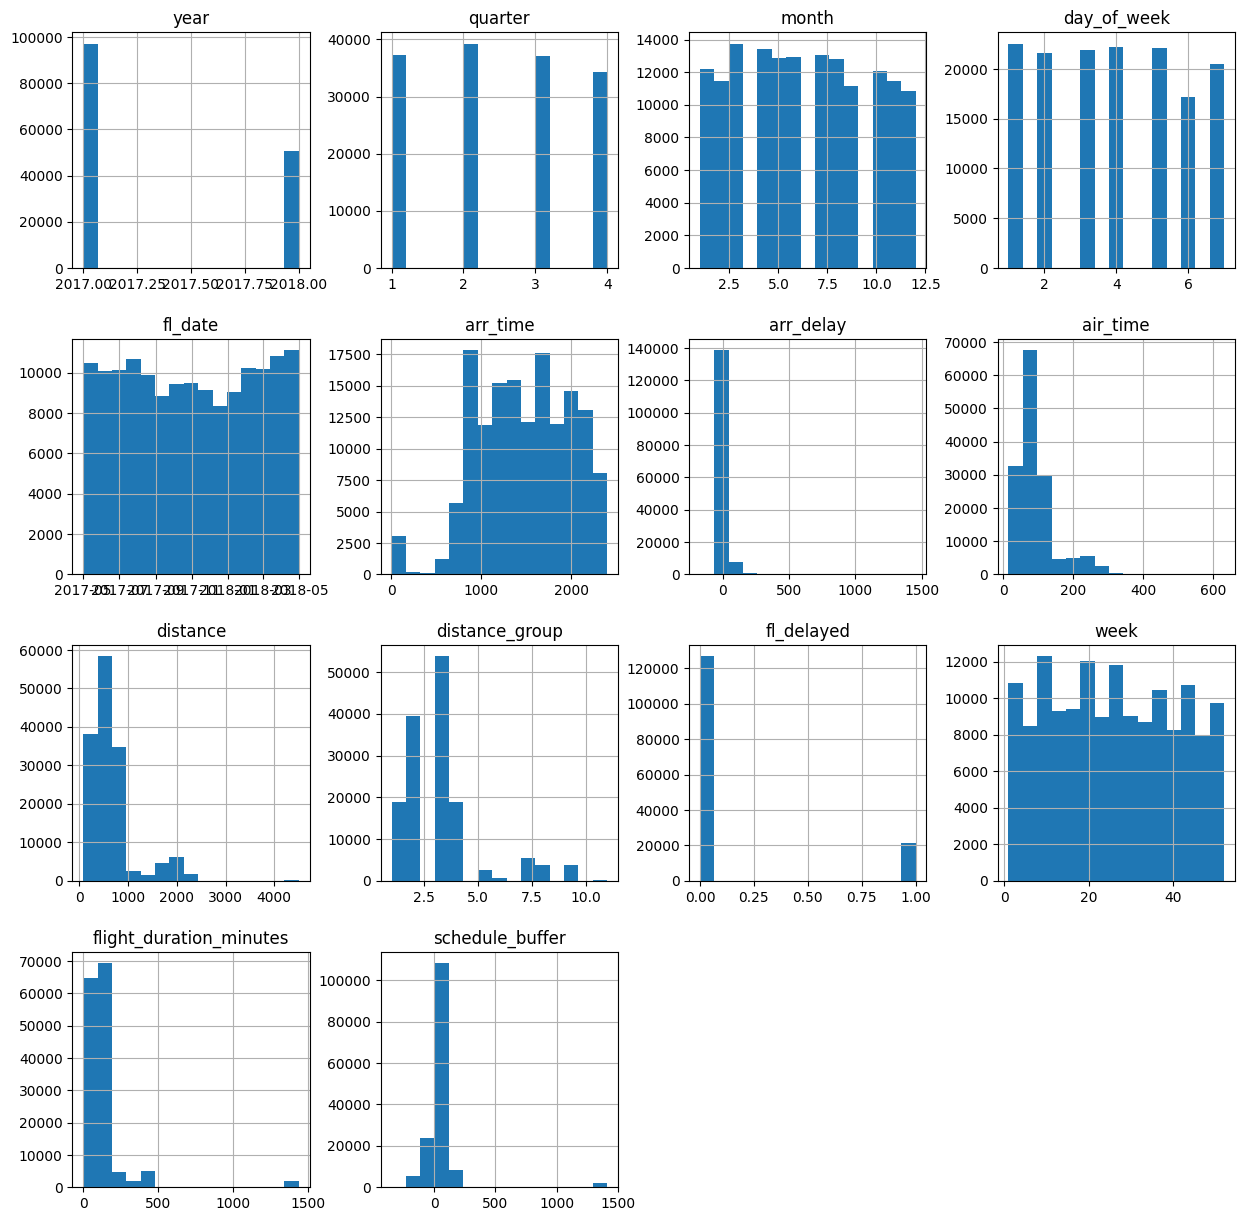

In [16]:
## Overall distribution of features

lst= df01.columns
df01[lst].hist(figsize = [15, 15],bins=15);

#### Step 4: Exploratory Data Analysis (EDA)
TEMPORAL PATTERN ANALYSIS

In [17]:
### Exploring flights date range
print(df01.fl_date.min(), df01.fl_date.max())

2017-05-01 00:00:00 2018-04-30 00:00:00


In [18]:
## Daily flight counts
df_plot = df01['fl_date'].value_counts().sort_index()
df_plot

fl_date
2017-05-01    456
2017-05-02    389
2017-05-03    436
2017-05-04    430
2017-05-05    418
             ... 
2018-04-26    465
2018-04-27    479
2018-04-28    346
2018-04-29    492
2018-04-30    455
Name: count, Length: 365, dtype: int64

<Axes: xlabel='fl_date'>

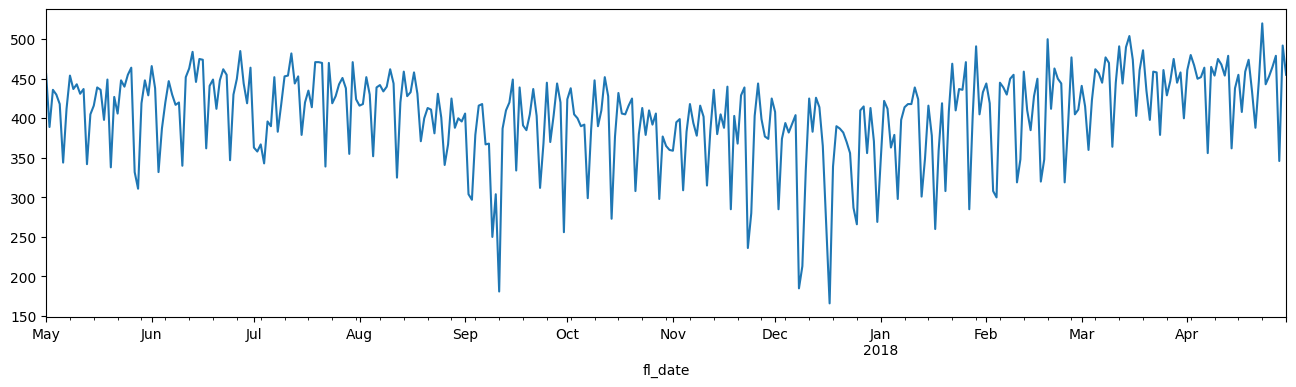

In [19]:
### Analyzing traffic volume or airline activity each day.

df_plot = df01['fl_date'].value_counts().sort_index()

plt.figure(figsize=(16,4))
df_plot.plot()

<Axes: xlabel='week'>

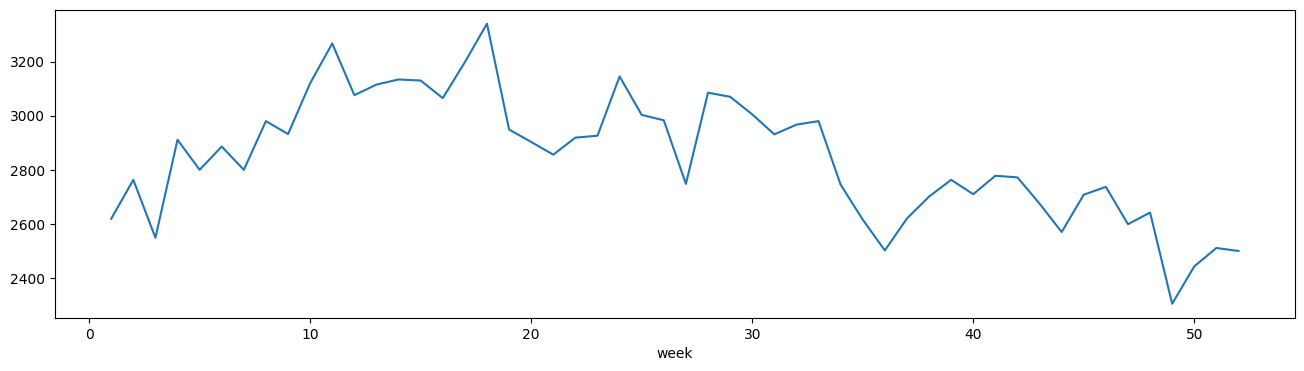

In [20]:
df_plot = df01['week'].value_counts().sort_index()

plt.figure(figsize=(16,4))
df_plot.plot()

##### Interpretation: Chart doesnot show weekly sasonality however there is a need of deep analysis so i will check data points after March 2018

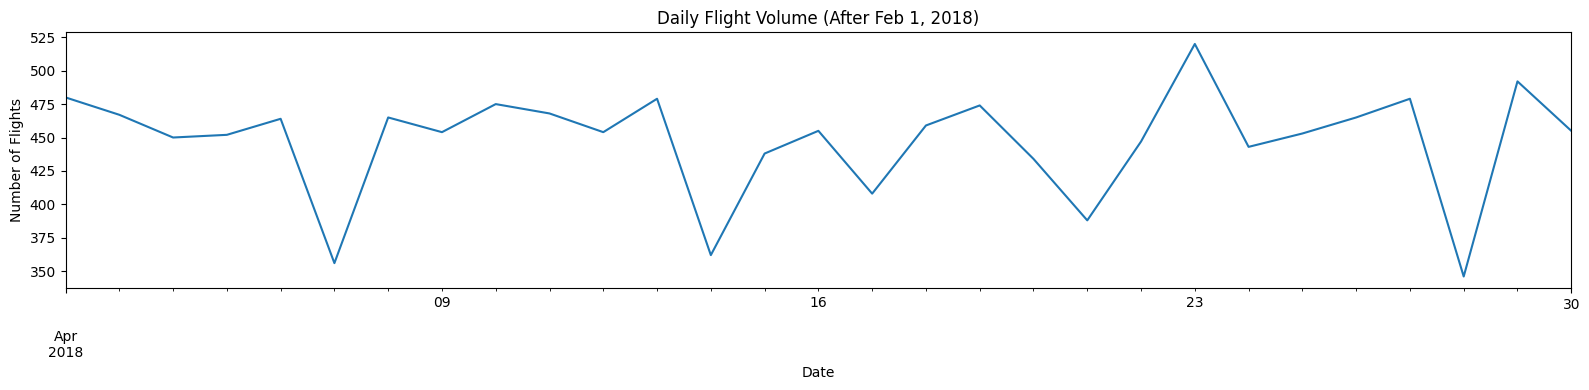

In [21]:

# Filter data for flights after Feb 1, 2018
df_filtered = df01[df01['fl_date'] > '2018-04-01']

df_plot = df_filtered['fl_date'].value_counts().sort_index()

plt.figure(figsize=(16, 4))
df_plot.plot(title='Daily Flight Volume (After Feb 1, 2018)')
plt.xlabel('Date')
plt.ylabel('Number of Flights')
plt.tight_layout()
plt.show()


##### Interpretation: Deep analysis reveals that 4 weeks data does not shows the seasonality in the data

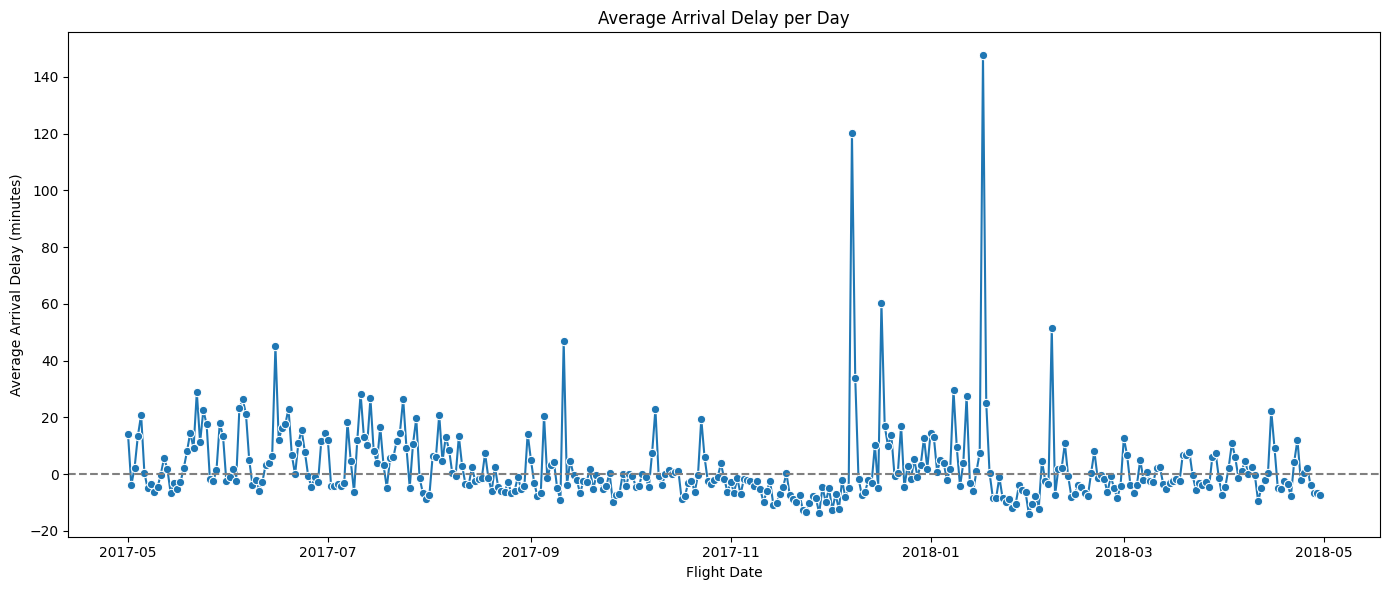

In [22]:
## The Daily average arrival delay across all flights on each date.

df_avg = df01.groupby('fl_date')['arr_delay'].mean().reset_index()

plt.figure(figsize=(14, 6))
sns.lineplot(data=df_avg, x='fl_date', y='arr_delay', marker='o')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Average Arrival Delay per Day')
plt.xlabel('Flight Date')
plt.ylabel('Average Arrival Delay (minutes)')
plt.tight_layout()
plt.show()


Arrival delays were most severe in summer 2017 and early 2018, with improvements in fall 2017. Seasonal factors (e.g., weather, holidays) may explain these patterns.

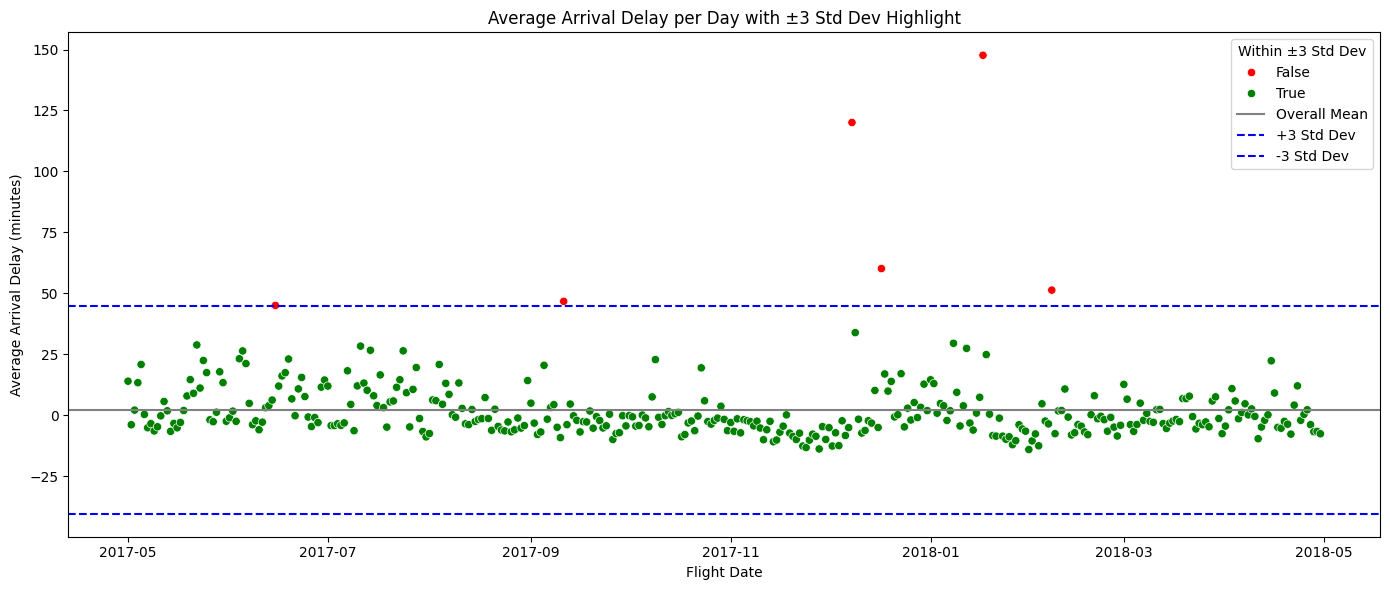

In [23]:
# Calculate daily average arrival delay
df_avg = df01.groupby('fl_date')['arr_delay'].mean().reset_index(name='mean_delay')

# Overall mean and std of daily averages
overall_mean = df_avg['mean_delay'].mean()
overall_std = df_avg['mean_delay'].std()

upper_bound = overall_mean + 3 * overall_std
lower_bound = overall_mean - 3 * overall_std

# Mark points within ±3 std dev
df_avg['within_3sd'] = df_avg['mean_delay'].between(lower_bound, upper_bound)

plt.figure(figsize=(14, 6))

# Plot all points
sns.scatterplot(
    data=df_avg,
    x='fl_date',
    y='mean_delay',
    hue='within_3sd',
    palette={True: 'green', False: 'red'},
    legend='brief'
)

# Plot overall mean and ±3 std deviation lines
plt.axhline(overall_mean, color='gray', linestyle='-', label='Overall Mean')
plt.axhline(upper_bound, color='blue', linestyle='--', label='+3 Std Dev')
plt.axhline(lower_bound, color='blue', linestyle='--', label='-3 Std Dev')

plt.title('Average Arrival Delay per Day with ±3 Std Dev Highlight')
plt.xlabel('Flight Date')
plt.ylabel('Average Arrival Delay (minutes)')
plt.legend(title='Within ±3 Std Dev')
plt.tight_layout()
plt.show()


Outliers: Points breach the +3 Std Dev line, those days had exceptionally severe delays.

In [24]:
df01.columns

Index(['year', 'quarter', 'month', 'day_of_week', 'fl_date', 'unique_carrier',
       'origin', 'dest', 'dest_state_abr', 'arr_time', 'arr_delay', 'air_time',
       'distance', 'distance_group', 'origin_state_city', 'dest_state_city',
       'fl_delayed', 'week', 'flight_duration_minutes', 'schedule_buffer'],
      dtype='object')

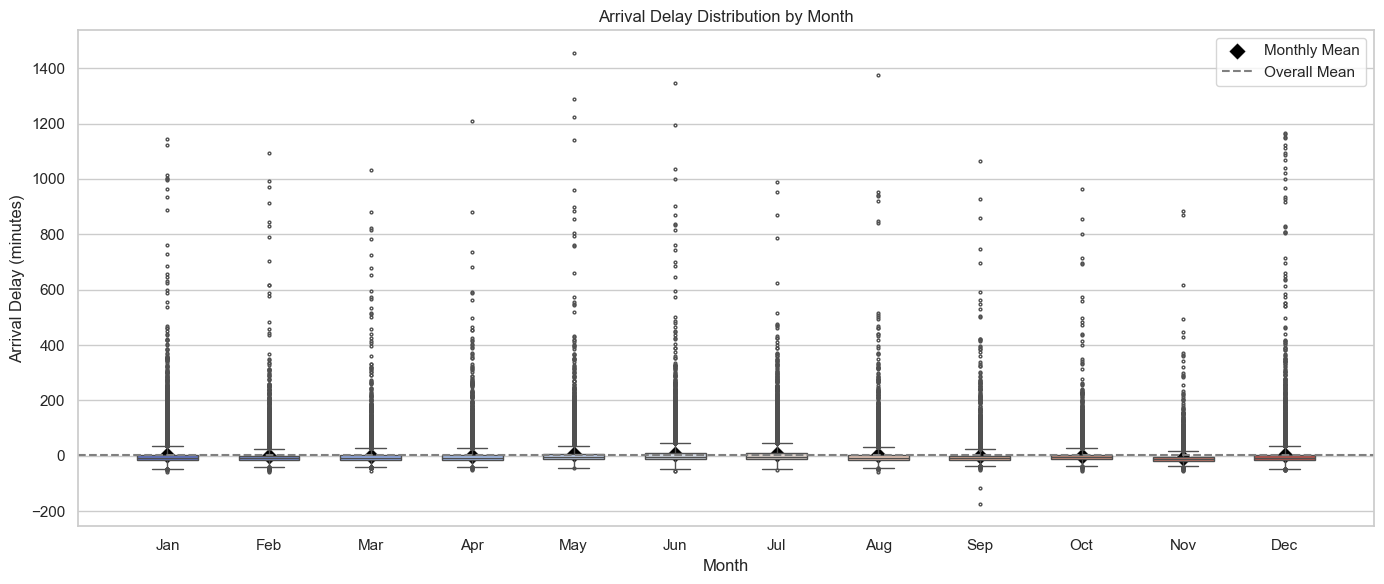

In [25]:
## Arrival Delay Distribution by Month
month_map = dict(zip(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']))
df01['month_name'] = df01['month'].map(month_map)

# Monthly mean delays
monthly_means = df01.groupby('month_name')['arr_delay'].mean().reindex(month_map.values())

# Plot
plt.figure(figsize=(14, 6))
sns.set(style='whitegrid')

sns.boxplot(data=df01, x='month_name', y='arr_delay',
            order=month_map.values(), palette='coolwarm', width=0.6, fliersize=2)

sns.scatterplot(x=monthly_means.index, y=monthly_means.values,
                color='black', s=80, marker='D', label='Monthly Mean')

plt.axhline(df01['arr_delay'].mean(), color='gray', linestyle='--', label='Overall Mean')

plt.title('Arrival Delay Distribution by Month')
plt.xlabel('Month')
plt.ylabel('Arrival Delay (minutes)')
plt.legend()
plt.tight_layout()
plt.show()



Comparing each month's mean delay to the overall mean, with delays typically being higher in winter months like January and December.

<Axes: xlabel='day_of_week'>

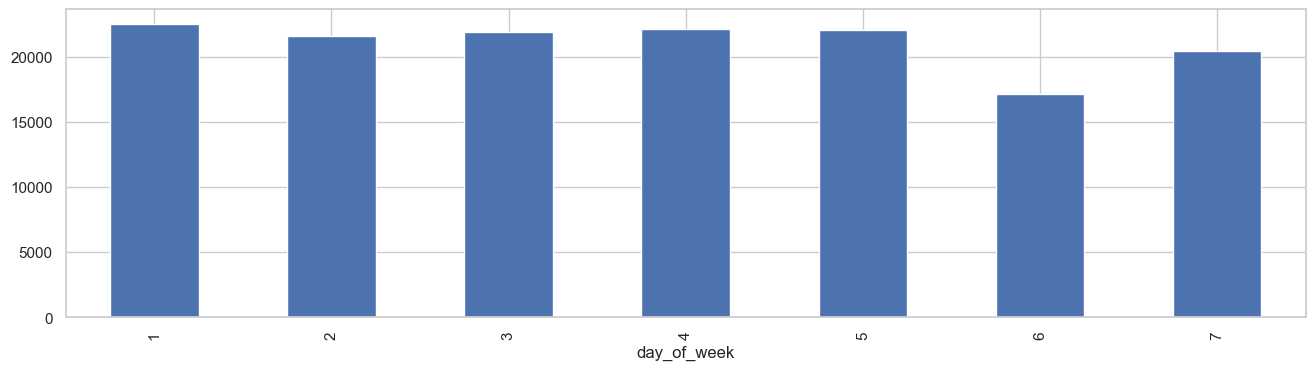

In [26]:
## ### Analyzing traffic volume or airline activity each day of the week.
dayofweek= df01["day_of_week"].value_counts().sort_index()
plt.figure(figsize=(16,4))
dayofweek.plot(kind='bar')


frequency of bar mention more flights on weekend or business trips

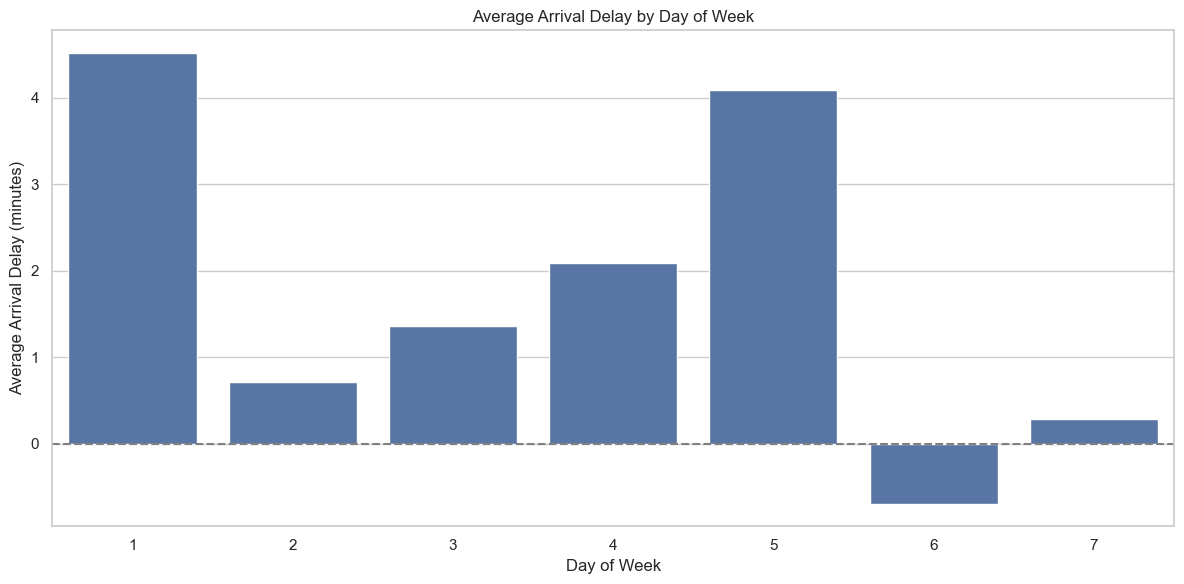

In [27]:
ordered_days = ['1', '2', '3', '4', '5', '6', '7']

# Barplot of mean delays
plt.figure(figsize=(12, 6))
sns.barplot(data=df01, x='day_of_week', y='arr_delay', order=ordered_days, ci=None)
plt.axhline(0, color='gray', linestyle='--')
plt.title('Average Arrival Delay by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Arrival Delay (minutes)')
plt.tight_layout()
plt.show()


1–5 show spikes (e.g., Monday=1 or Friday=5), it could link to business travel congestion or system-wide Monday backups.

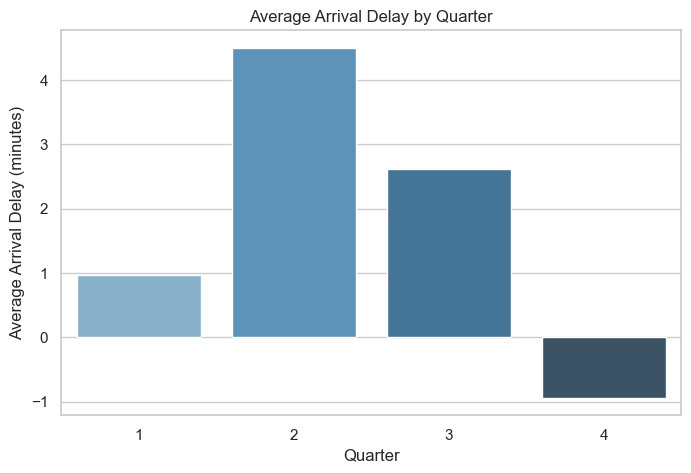

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Example DataFrame df with columns: 'quarter', 'arr_delay'

# 1) Average arrival delay per quarter
avg_delay = df.groupby('quarter')['arr_delay'].mean().reset_index()

# Plot average delay by quarter
plt.figure(figsize=(8,5))
sns.barplot(data=avg_delay, x='quarter', y='arr_delay', palette='Blues_d')
plt.title('Average Arrival Delay by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Average Arrival Delay (minutes)')
plt.show()




This chart shows the second quarter has more delays due to more traffic in summer time.

In [29]:
## Added is_weekend and is_holiday to check the traffic and missing values
df01['is_weekend']= df01['day_of_week'].isin([6,7]).astype("int")

# U.S. holidays between the years in the  data
us_holidays = holidays.UnitedStates(years=range(df01['fl_date'].dt.year.min(), df01['fl_date'].dt.year.max()+1))

df01['is_holiday'] = df01['fl_date'].isin(us_holidays).astype(int)
df01.head(3)

,year,quarter,month,day_of_week,fl_date,unique_carrier,origin,dest,dest_state_abr,arr_time,...,distance_group,origin_state_city,dest_state_city,fl_delayed,week,flight_duration_minutes,schedule_buffer,month_name,is_weekend,is_holiday
0,2017,3,7,2,2017-07-11,DL,LIT,ATL,GA,757,...,2,AR : LIT,GA : ATL,0,28,139,75,Jul,0,0
1,2018,1,3,3,2018-03-14,DL,BOS,ATL,GA,2108,...,4,MA : BOS,GA : ATL,0,11,159,32,Mar,0,0
2,2017,4,11,7,2017-11-12,WN,ATL,DAL,TX,1451,...,3,GA : ATL,TX : DAL,0,45,66,-40,Nov,1,0


In [30]:
## checking for missing data either related to newly created columns or arrival time
df01[df01['arr_delay'].isna()][['arr_delay', 'is_weekend', 'is_holiday']]

,arr_delay,is_weekend,is_holiday
4026,NaN,1,0
8699,NaN,0,1
12382,NaN,0,0
12504,NaN,0,0
12545,NaN,1,0
...,...,...,...
137131,NaN,1,0
138953,NaN,0,0
140931,NaN,0,0
144855,NaN,0,0


In [31]:
## Droping missing values might be related to the cancelled flights
df01.dropna(inplace= True)

In [32]:
df01.columns

Index(['year', 'quarter', 'month', 'day_of_week', 'fl_date', 'unique_carrier',
       'origin', 'dest', 'dest_state_abr', 'arr_time', 'arr_delay', 'air_time',
       'distance', 'distance_group', 'origin_state_city', 'dest_state_city',
       'fl_delayed', 'week', 'flight_duration_minutes', 'schedule_buffer',
       'month_name', 'is_weekend', 'is_holiday'],
      dtype='object')

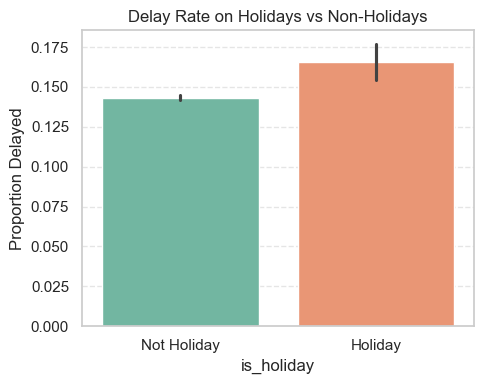

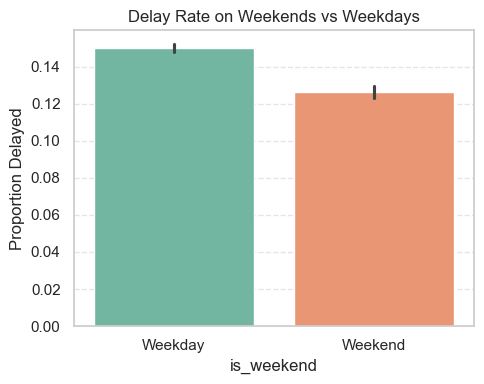

In [33]:
# Plot delay rate by is_holiday
plt.figure(figsize=(5, 4))
sns.barplot(data=df01, x='is_holiday', y='fl_delayed', palette='Set2')
plt.xticks([0, 1], ['Not Holiday', 'Holiday'])
plt.title('Delay Rate on Holidays vs Non-Holidays')
plt.ylabel('Proportion Delayed')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Plot delay rate by is_weekend
plt.figure(figsize=(5, 4))
sns.barplot(data=df01, x='is_weekend', y='fl_delayed', palette='Set2')
plt.xticks([0, 1], ['Weekday', 'Weekend'])
plt.title('Delay Rate on Weekends vs Weekdays')
plt.ylabel('Proportion Delayed')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



"Analysis indicates that flights scheduled on holidays have a significantly higher likelihood of experiencing delays compared to those on regular days."

"This pattern may be due to increased demand, operational strain, or weather variability during holiday seasons."

##### OPERATIONAL PERFORMANCE

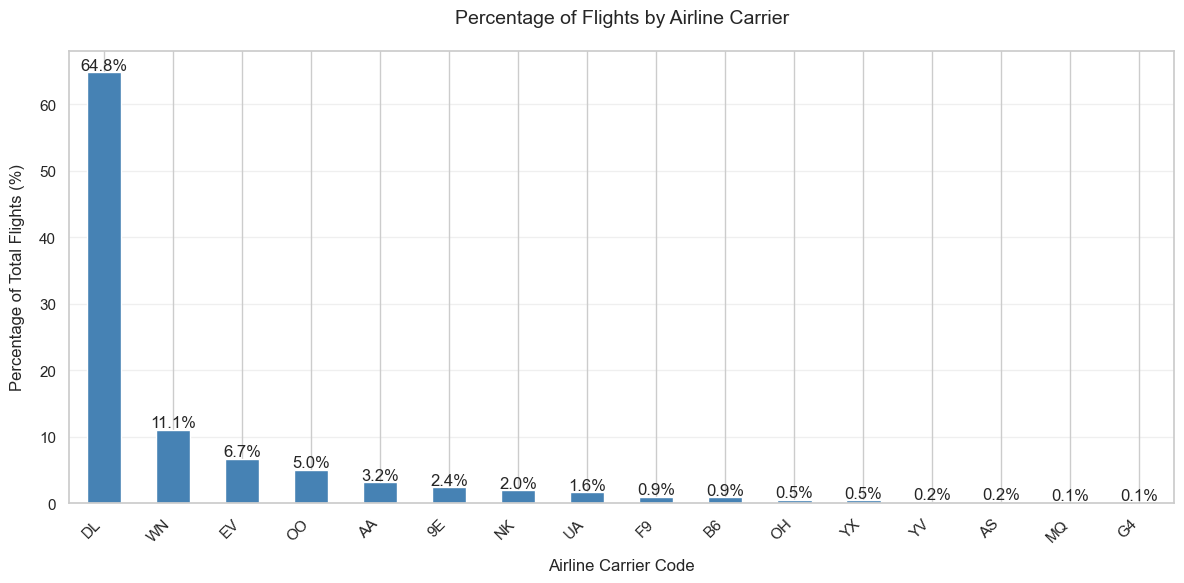

In [34]:
# Calculate and display carrier percentages
carrier_pct = (df01['unique_carrier'].value_counts(normalize=True) * 100)
##print("Percentage of flights by carrier:\n", carrier_pct.round(3))

# Create improved visualization
plt.figure(figsize=(12, 6))
ax = carrier_pct.plot(kind='bar', color='steelblue')

# Formatting
plt.title('Percentage of Flights by Airline Carrier', pad=20, size=14)
plt.xlabel('Airline Carrier Code', labelpad=10)
plt.ylabel('Percentage of Total Flights (%)', labelpad=10)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points')

plt.tight_layout()
plt.show()

In [35]:
## Mean delay by carrier
carrier_delay = df01.groupby('unique_carrier')['fl_delayed'].mean().sort_values(ascending=False)
print(carrier_delay)

unique_carrier
B6    0.222136
OO    0.211453
WN    0.200550
OH    0.197564
F9    0.188176
EV    0.185144
G4    0.175824
UA    0.171440
MQ    0.169811
NK    0.168605
AA    0.167595
9E    0.157865
YV    0.129310
DL    0.120045
YX    0.113905
AS    0.106870
Name: fl_delayed, dtype: float64


In [36]:
# Compare delay rates by carrier AND holiday status
df01.groupby(['unique_carrier', 'is_holiday'])['fl_delayed'].mean().unstack()

is_holiday,0,1
unique_carrier,,
9E,0.157476,0.172043
AA,0.167073,0.182390
AS,0.105058,0.200000
B6,0.219078,0.304348
DL,0.119348,0.144817
EV,0.183684,0.247788
F9,0.181347,0.444444
G4,0.183908,0.000000
MQ,0.173077,0.000000


- Worst Holiday Performers:

F9 (Frontier): Delay rate jumps from 18.1% → 44.4% on holidays.

B6 (JetBlue): 21.9% → 30.4%.

OH (PSA Airlines): 19.5% → 29.4%.

- Best Holiday Performers:

UA (United): Drops from 17.3% → 12.9%.

WN (Southwest): 20.1% → 17.2%.

In [37]:
### Created CarrirDelayRate Column indicating its airline's historical delay probability
carrier_delay = df01.groupby('unique_carrier')['fl_delayed'].mean().round(3)

df01['CarrirDelayRate'] = df01['unique_carrier'].map(carrier_delay)

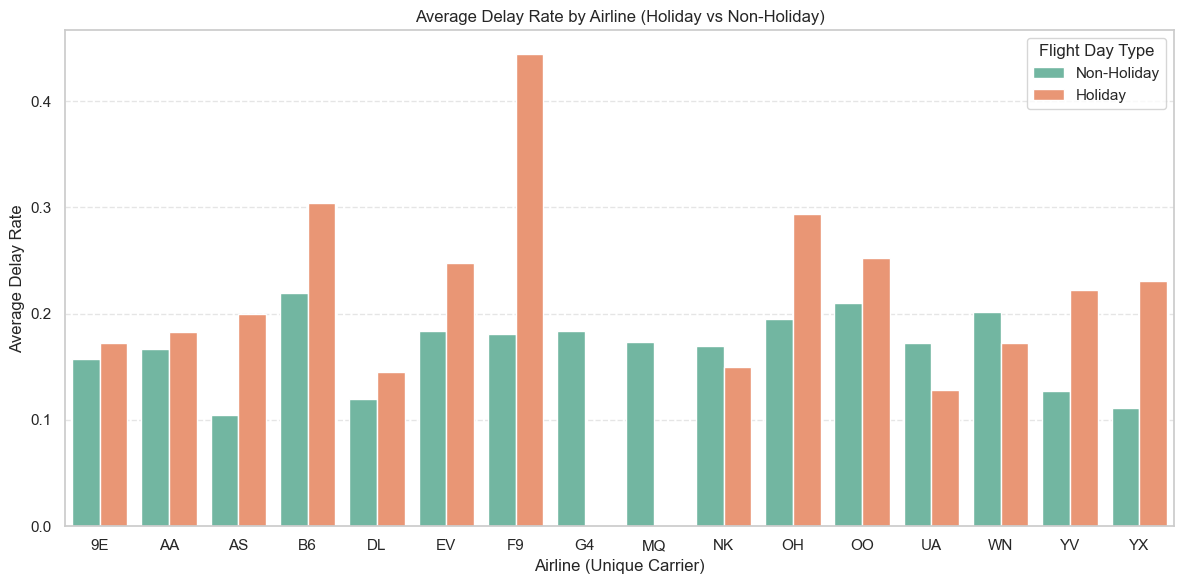

In [38]:
# Created a new DataFrame summarizing delay rate by carrier and holiday status
carrier_holiday_delay = (
    df01.groupby(['unique_carrier', 'is_holiday'])['fl_delayed']
    .mean()
    .reset_index()
)

# Convert is_holiday to readable labels
carrier_holiday_delay['Holiday'] = carrier_holiday_delay['is_holiday'].map({0: 'Non-Holiday', 1: 'Holiday'})

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=carrier_holiday_delay,
    x='unique_carrier',
    y='fl_delayed',
    hue='Holiday',
    palette='Set2'
)

plt.title('Average Delay Rate by Airline (Holiday vs Non-Holiday)')
plt.ylabel('Average Delay Rate')
plt.xlabel('Airline (Unique Carrier)')
plt.legend(title='Flight Day Type')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


- Some airlines are more affected by holiday pressure.

- F9 (Frontier) shows a dramatic increase in delay rate.

- B6, OH, and YX also experience significant holiday spikes.

- Major carriers like DL and WN remain relatively consistent, showing strong operational control even during holidays.



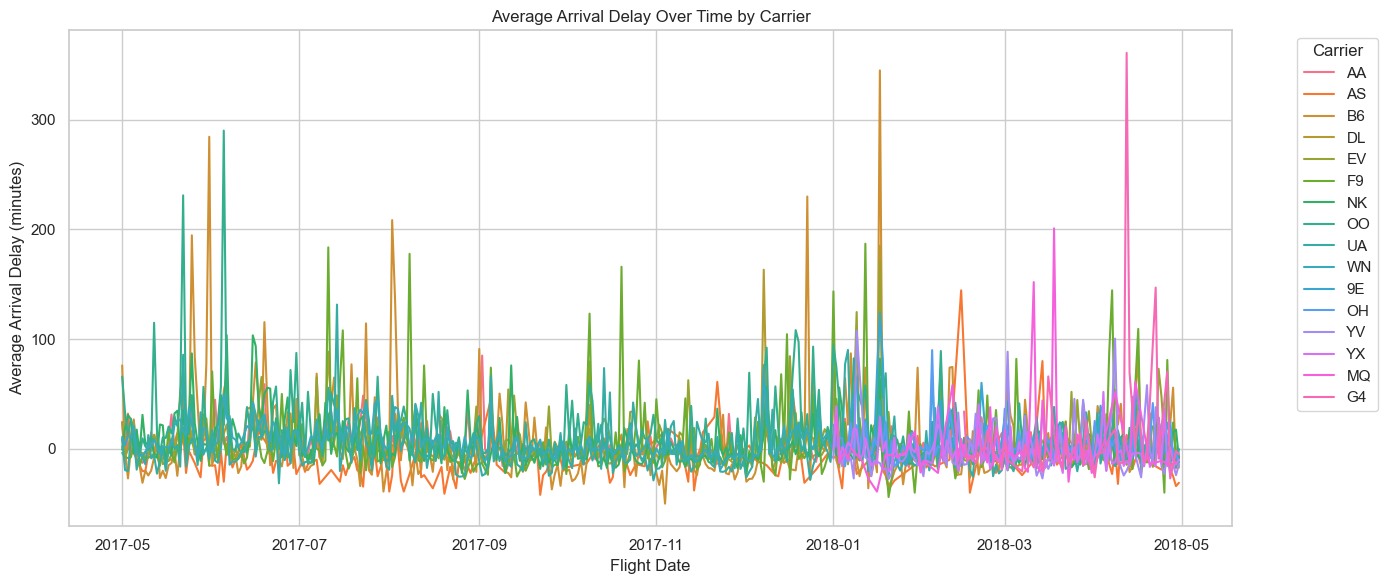

In [39]:

df_line = df01.groupby(['fl_date', 'unique_carrier'])['arr_delay'].mean().reset_index()

# Plot line chart
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_line,
             x='fl_date',
             y='arr_delay',
             hue='unique_carrier')

plt.title('Average Arrival Delay Over Time by Carrier')
plt.xlabel('Flight Date')
plt.ylabel('Average Arrival Delay (minutes)')
plt.legend(title='Carrier', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


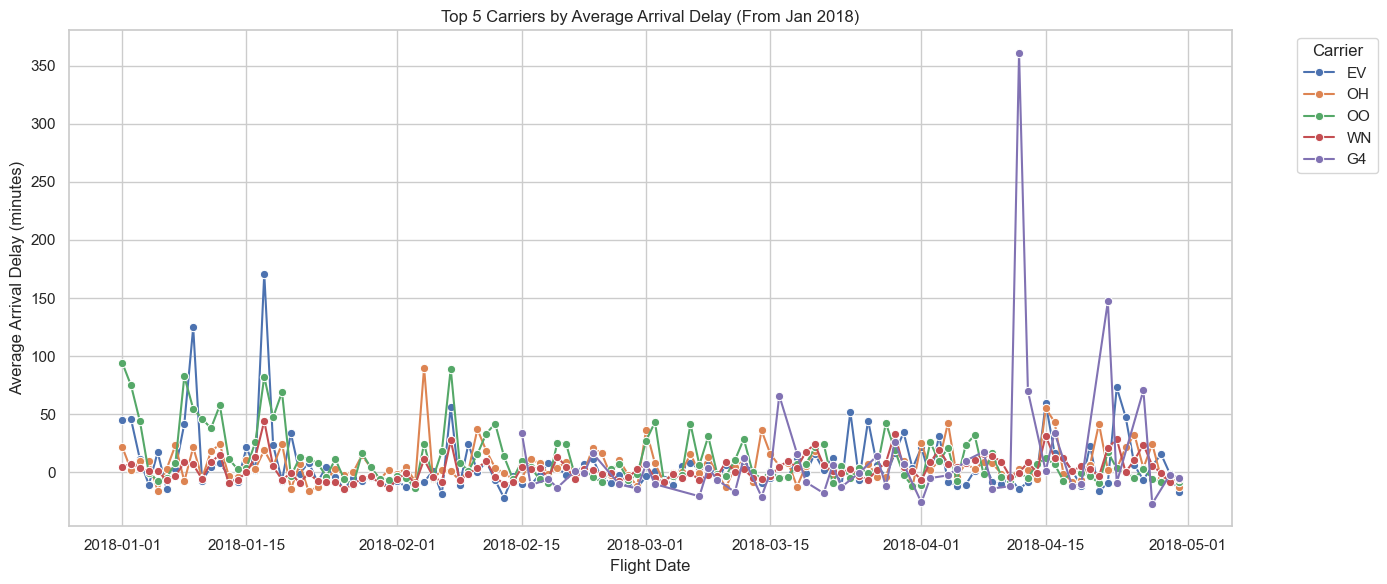

In [40]:
##  Identify top 5 carriers with highest average delay
top_5_carriers = df01.groupby('unique_carrier')['arr_delay'].mean().sort_values(ascending=False).head(5).index

df_top5 = df01[
    (df['unique_carrier'].isin(top_5_carriers)) &
    (df['fl_date'] >= '2018-01-01')
]

df_line = df_top5.groupby(['fl_date', 'unique_carrier'])['arr_delay'].mean().reset_index()

# Step 4: Plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_line, x='fl_date', y='arr_delay', hue='unique_carrier', marker='o')

plt.title('Top 5 Carriers by Average Arrival Delay (From Jan 2018)')
plt.xlabel('Flight Date')
plt.ylabel('Average Arrival Delay (minutes)')
plt.legend(title='Carrier', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


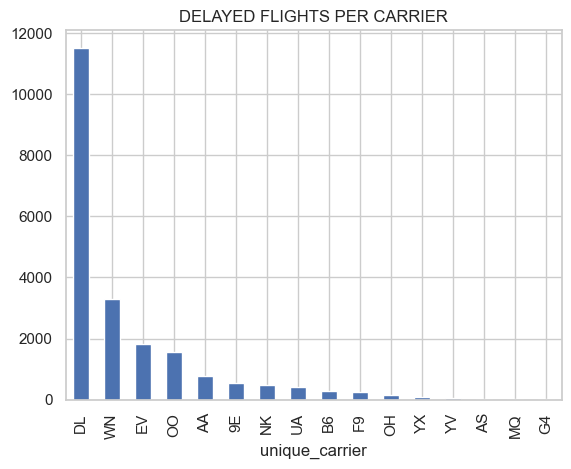

In [41]:
# Plot bar plot for Delayed Flight per carrier

df01[df01['arr_delay']> 15]['unique_carrier'].value_counts().plot(kind='bar')
plt.title('DELAYED FLIGHTS PER CARRIER')
plt.show()

Flights with Negative Buffer:
       flight_duration_minutes      air_time  schedule_buffer
count             29255.000000  29255.000000     29255.000000
mean                 66.673321    131.216681       -64.543360
std                  37.616134     76.404895        48.496622
min                   0.000000     24.000000      -349.000000
25%                  41.000000     80.000000       -93.000000
50%                  65.000000    105.000000       -42.000000
75%                  86.000000    168.000000       -36.000000
max                 359.000000    631.000000        -1.000000


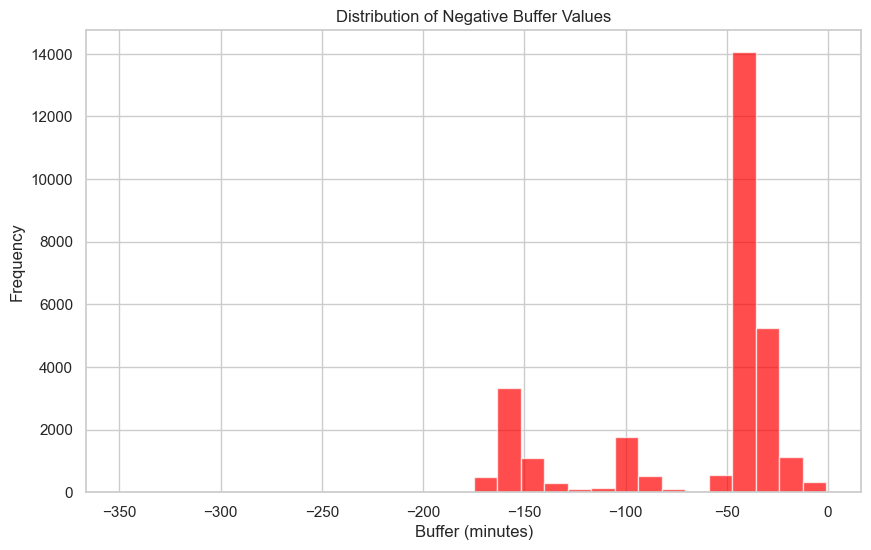

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter rows with negative buffer
negative_buffer_flights = df[df['schedule_buffer'] < 0]

# Display summary stats
print("Flights with Negative Buffer:")
print(negative_buffer_flights[['flight_duration_minutes', 'air_time', 'schedule_buffer']].describe())

# Plot distribution of negative buffers
plt.figure(figsize=(10, 6))
plt.hist(negative_buffer_flights['schedule_buffer'], bins=30, color='red', alpha=0.7)
plt.title("Distribution of Negative Buffer Values")
plt.xlabel("Buffer (minutes)")
plt.ylabel("Frequency")
plt.show()

The highest frequency occurs around -50 to -100 minutes, suggesting:

Many flights faced moderate delays (e.g., 1–1.5 hours longer in the air than scheduled).

Possible causes:Air traffic congestion, Weather-related holding patterns, Route changes (e.g., headwinds, rerouting).

In [43]:
df01.columns

Index(['year', 'quarter', 'month', 'day_of_week', 'fl_date', 'unique_carrier',
       'origin', 'dest', 'dest_state_abr', 'arr_time', 'arr_delay', 'air_time',
       'distance', 'distance_group', 'origin_state_city', 'dest_state_city',
       'fl_delayed', 'week', 'flight_duration_minutes', 'schedule_buffer',
       'month_name', 'is_weekend', 'is_holiday', 'CarrirDelayRate'],
      dtype='object')

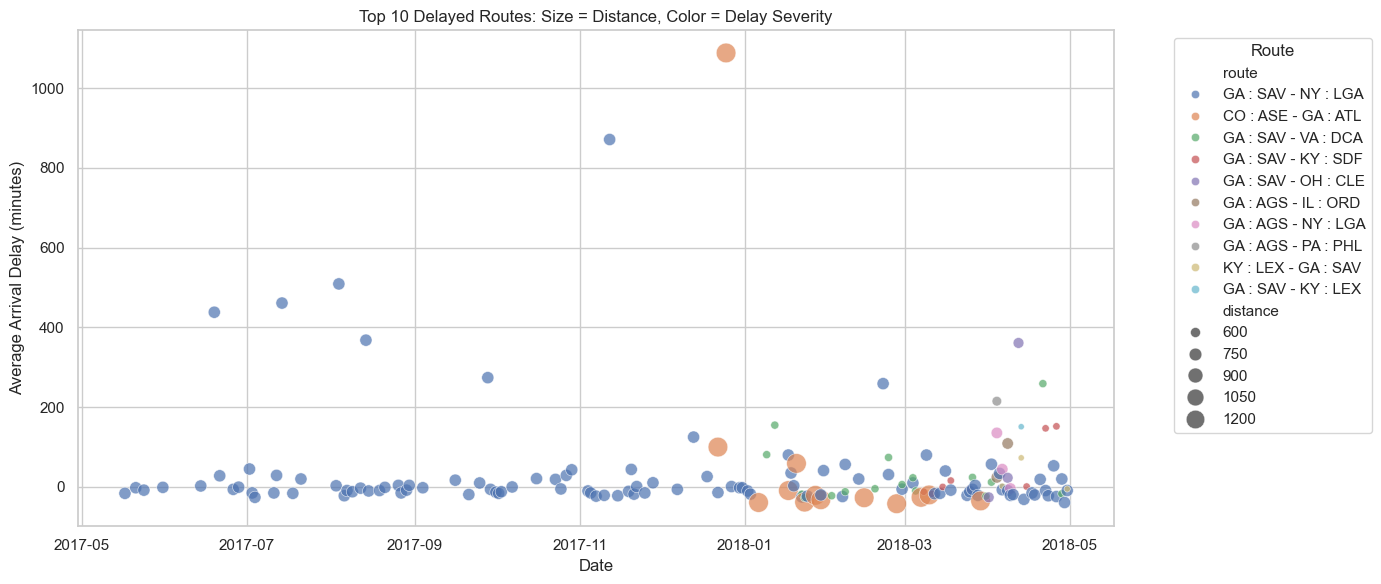

In [44]:
# Top 10 Routes by Avg Delay Over Time (Point Size ~ Distance)
df01['route'] = df01['origin_state_city'] + " - " + df01['dest_state_city']

top_routes = (
    df01.groupby('route')['arr_delay']
    .mean()
    .nlargest(10)
    .index
)

df_top_routes = df01[df01['route'].isin(top_routes)]

avg_delay_route = (
    df_top_routes
    .groupby(['fl_date', 'route'])[['arr_delay', 'distance']]
    .mean()
    .reset_index()
)

plt.figure(figsize=(14, 6))
sns.scatterplot(
    data=avg_delay_route,
    x='fl_date',
    y='arr_delay',
    hue='route',
    size='distance',
    sizes=(20, 200),
    alpha=0.7
)

plt.title("Top 10 Delayed Routes: Size = Distance, Color = Delay Severity")
plt.xlabel('Date')
plt.ylabel('Average Arrival Delay (minutes)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Route')
plt.tight_layout()
plt.show()



SAV-LGA and ASE-ATL, which are chronically delayed.Travelers avoid summer and holiday travel on these routes; opt for fall for better punctuality.

In [45]:
df01['route_delay_rate'] = df01.groupby('route')['fl_delayed'].transform('mean')

In [46]:
df01.columns

Index(['year', 'quarter', 'month', 'day_of_week', 'fl_date', 'unique_carrier',
       'origin', 'dest', 'dest_state_abr', 'arr_time', 'arr_delay', 'air_time',
       'distance', 'distance_group', 'origin_state_city', 'dest_state_city',
       'fl_delayed', 'week', 'flight_duration_minutes', 'schedule_buffer',
       'month_name', 'is_weekend', 'is_holiday', 'CarrirDelayRate', 'route',
       'route_delay_rate'],
      dtype='object')

#### Target feature

In [47]:
df01['fl_delayed'].value_counts()

fl_delayed
0    126673
1     21312
Name: count, dtype: int64

FLIGHT STATUS - Count and Percentage


,COUNT,PERCENTAGE
fl_delayed,,
0,126673,85.6
1,21312,14.4


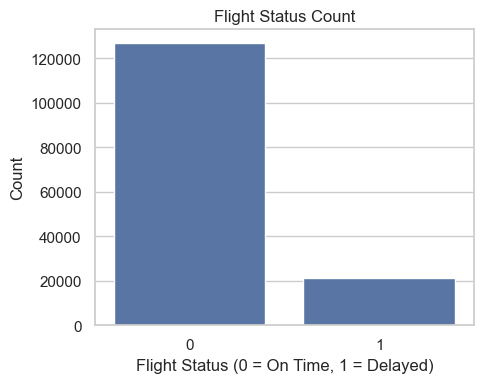

In [48]:
print('FLIGHT STATUS - Count and Percentage')

# Count occurrences of each flight status (0 or 1)
flight_count = df01['fl_delayed'].value_counts().sort_index().rename('COUNT')

# Total number of records
total_cnt = len(df01['fl_delayed'])

# Calculate percentage
rate_cnt = round(flight_count / total_cnt * 100, 2).rename('PERCENTAGE')

# Combine into a single DataFrame
result = pd.concat([flight_count, rate_cnt], axis=1)
display(result)

# Plot
plt.figure(figsize=(5, 4))
sns.countplot(data=df01, x='fl_delayed')
plt.title('Flight Status Count')
plt.xlabel('Flight Status (0 = On Time, 1 = Delayed)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


### EDA - Further analysis 

1. Day of Week and Time of Day( Monrning, afternoon, evening and night) analysis


In [49]:

# Convert arr_time (e.g., 2300, 2400, 100) to hour format safely
df01['arr_time'] = df01['arr_time'].replace(2400, 0)  # Replace 2400 with 0:00 (midnight)
df01['arr_time'] = df01['arr_time'].apply(lambda x: f"{int(x):04d}")  # Ensure 4-digit string
df01['arr_hour'] = pd.to_datetime(df01['arr_time'], format='%H%M', errors='coerce').dt.hour

# Check conversion result
print(df01['arr_hour'].min(), df01['arr_hour'].max())  # Should be 0 to 23

# Define bins and labels
bins = [-1, 4, 11, 16, 20, 23]
labels = ['Late Night', 'Morning', 'Afternoon', 'Evening', 'Night']

# Create time-of-day categories
df01['arr_time_period'] = pd.cut(df01['arr_hour'], bins=bins, labels=labels, ordered=True)


# Optional: Preview results
print(df01[['arr_time','arr_delay', 'arr_time_period']].head())


0 23
  arr_time  arr_delay arr_time_period
0     0757      -11.0         Morning
1     2108      -23.0           Night
2     1451       -9.0       Afternoon
3     1408      -21.0       Afternoon
4     0737      -19.0         Morning


In [50]:
print(df01['arr_time'].max(), df01['arr_time'].min())

2359 0000


In [51]:
df01['arr_time_period'].value_counts()

arr_time_period
Afternoon     45859
Morning       42629
Evening       35051
Night         21097
Late Night     3349
Name: count, dtype: int64

In [52]:
df01.columns

Index(['year', 'quarter', 'month', 'day_of_week', 'fl_date', 'unique_carrier',
       'origin', 'dest', 'dest_state_abr', 'arr_time', 'arr_delay', 'air_time',
       'distance', 'distance_group', 'origin_state_city', 'dest_state_city',
       'fl_delayed', 'week', 'flight_duration_minutes', 'schedule_buffer',
       'month_name', 'is_weekend', 'is_holiday', 'CarrirDelayRate', 'route',
       'route_delay_rate', 'arr_hour', 'arr_time_period'],
      dtype='object')

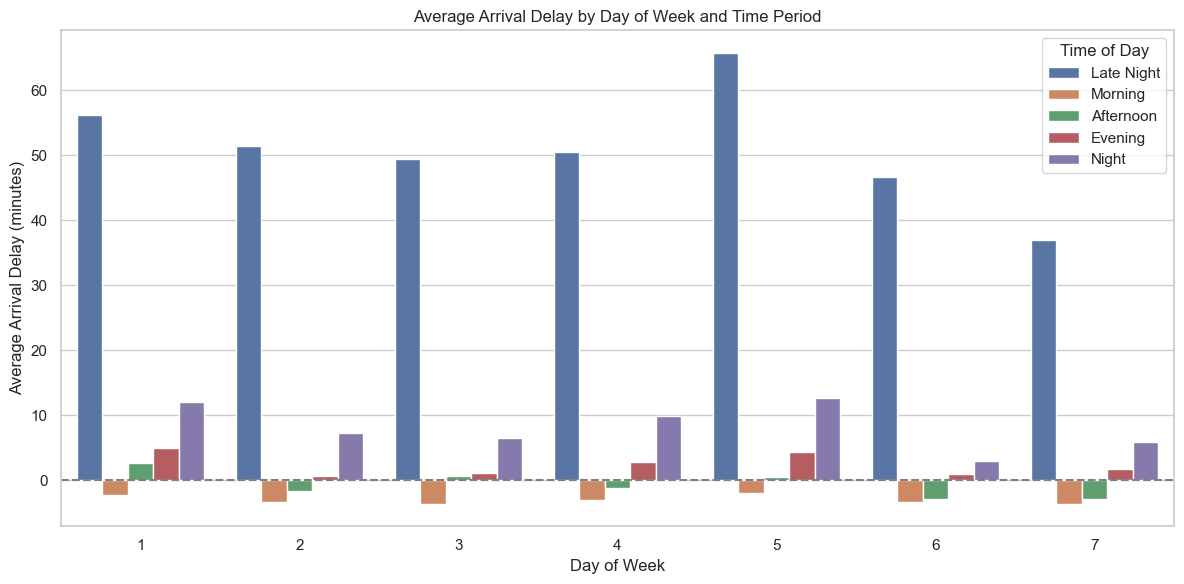

In [53]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df01,
    x='day_of_week',
    y='arr_delay',
    hue='arr_time_period',
    ci=None
)
plt.axhline(0, color='gray', linestyle='--')
plt.title("Average Arrival Delay by Day of Week and Time Period")
plt.xlabel("Day of Week")
plt.ylabel("Average Arrival Delay (minutes)")
plt.legend(title="Time of Day")
plt.tight_layout()
plt.show()


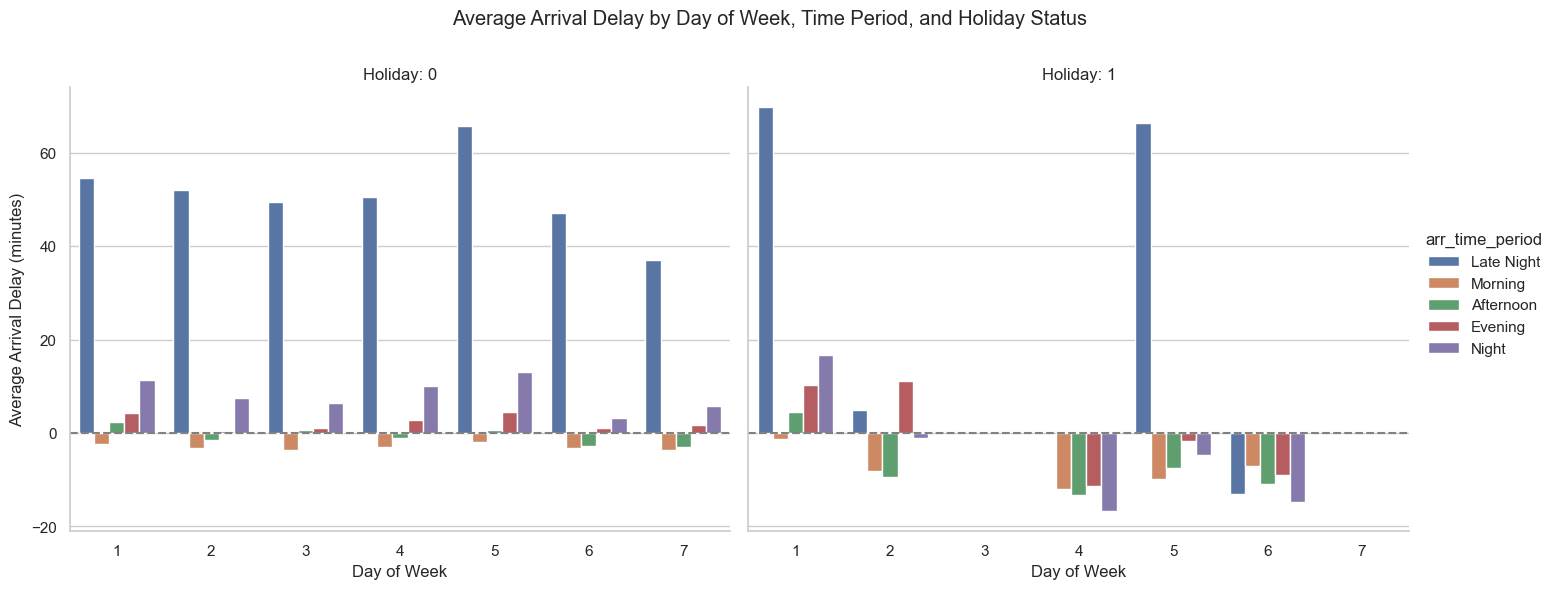

In [54]:
g = sns.catplot(
    data=df01,
    x='day_of_week',
    y='arr_delay',
    hue='arr_time_period',
    col='is_holiday',
    kind='bar',
    ci=None,
    height=6,
    aspect=1.2
)
g.set_titles("Holiday: {col_name}")
g.set_axis_labels("Day of Week", "Average Arrival Delay (minutes)")
for ax in g.axes.flat:
    ax.axhline(0, color='gray', linestyle='--')
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Average Arrival Delay by Day of Week, Time Period, and Holiday Status")
plt.show()


In [55]:
df01.columns

Index(['year', 'quarter', 'month', 'day_of_week', 'fl_date', 'unique_carrier',
       'origin', 'dest', 'dest_state_abr', 'arr_time', 'arr_delay', 'air_time',
       'distance', 'distance_group', 'origin_state_city', 'dest_state_city',
       'fl_delayed', 'week', 'flight_duration_minutes', 'schedule_buffer',
       'month_name', 'is_weekend', 'is_holiday', 'CarrirDelayRate', 'route',
       'route_delay_rate', 'arr_hour', 'arr_time_period'],
      dtype='object')

2. Destination Impacted by day time period

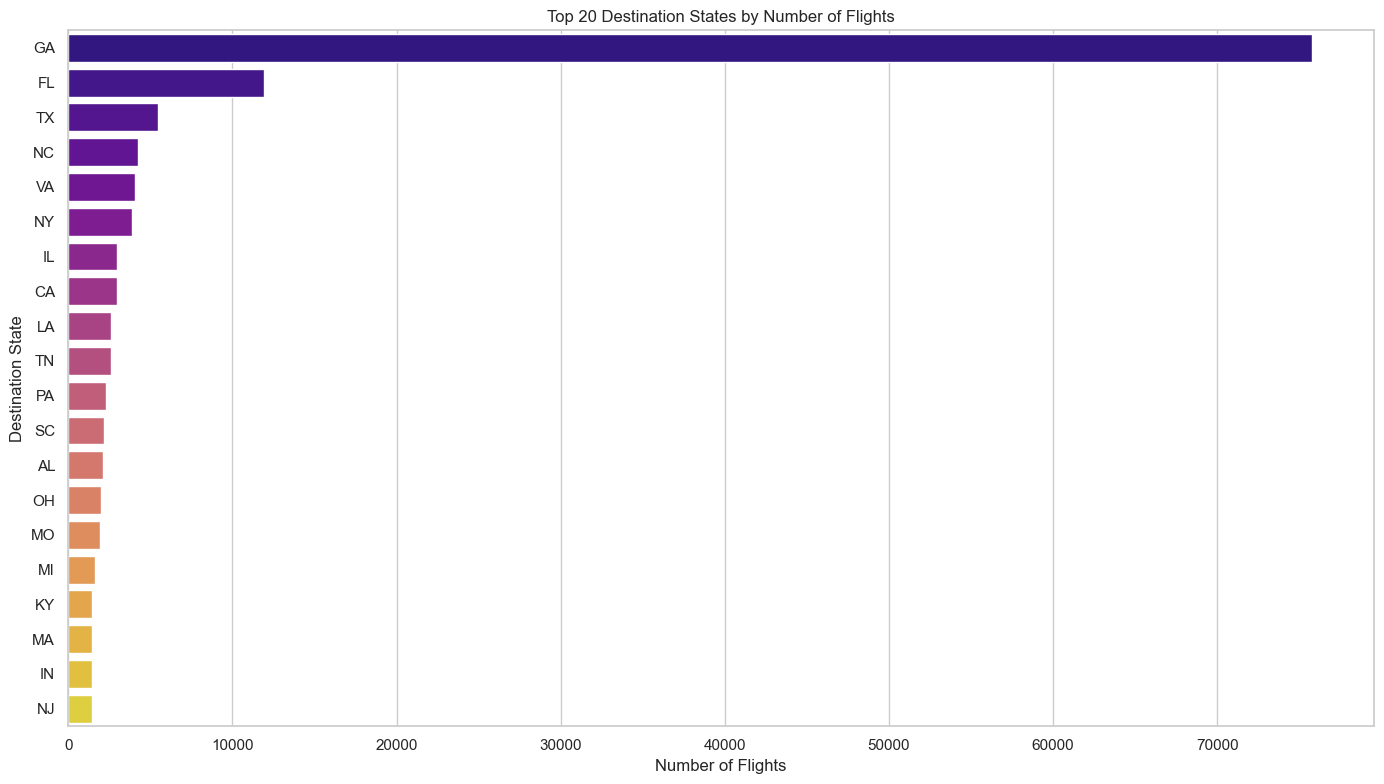

In [56]:
plt.figure(figsize=(14, 8))
sns.countplot(y='dest_state_abr', data=df01, order=df['dest_state_abr'].value_counts().index[:20], palette='plasma')
plt.title('Top 20 Destination States by Number of Flights')
plt.xlabel('Number of Flights')
plt.ylabel('Destination State')
plt.tight_layout()
plt.show()



3. Top 20 Destination States by Number of Delayed Flights and Time of Day?

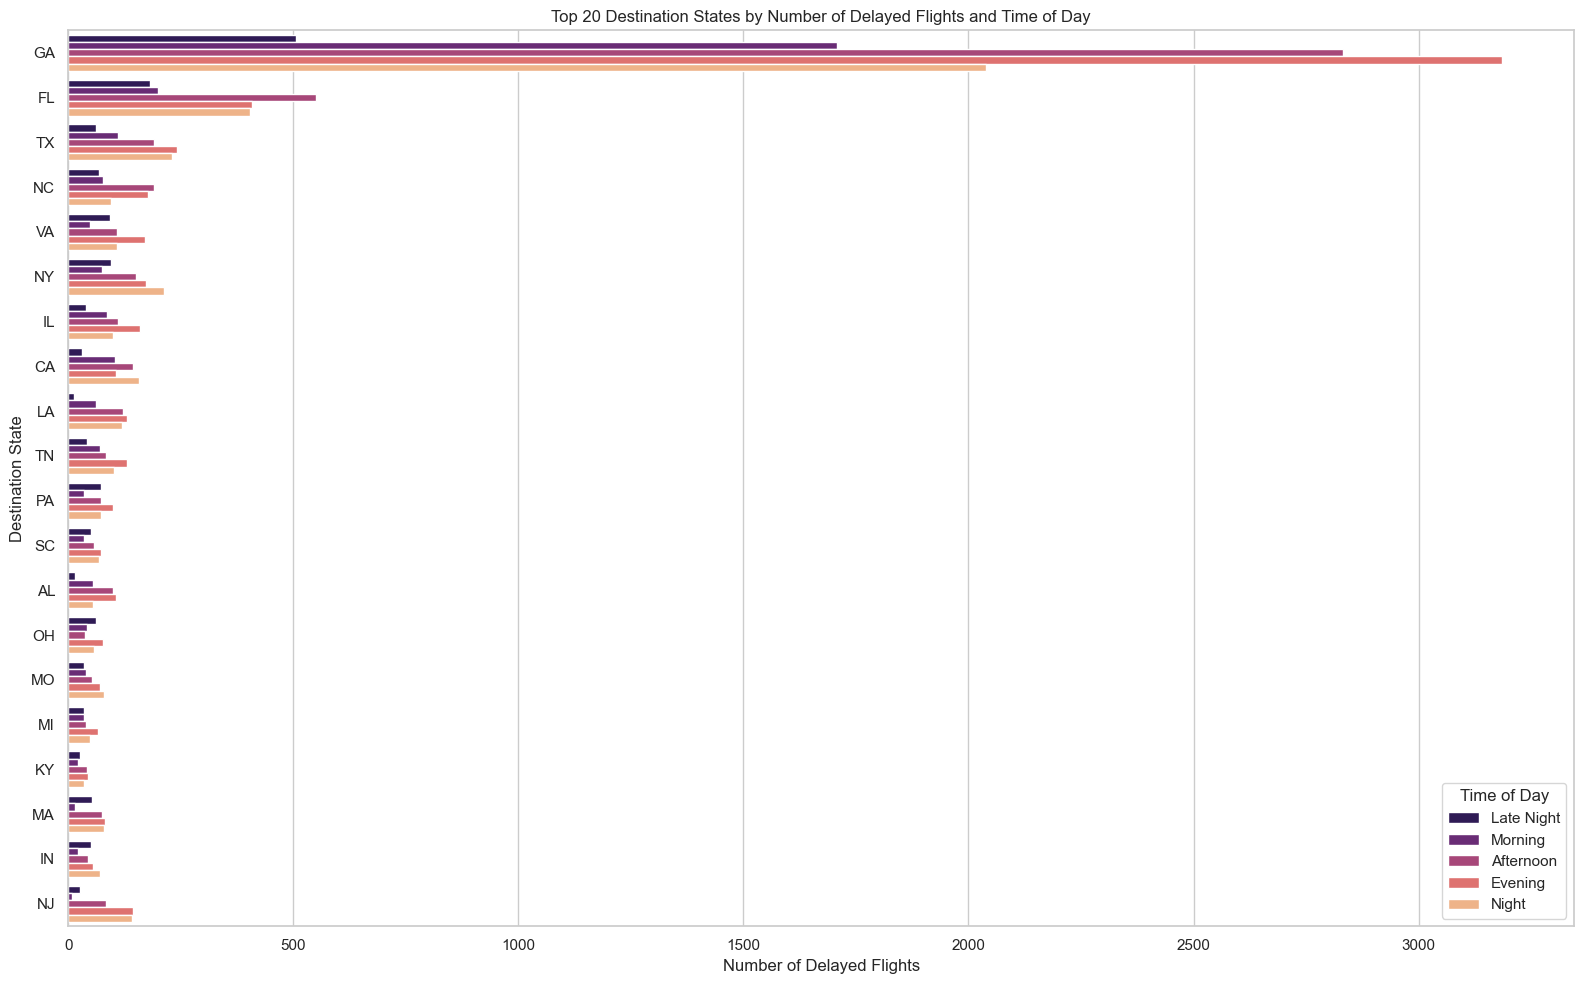

In [57]:

df01['is_delayed'] = df01['arr_delay'] > 15

plt.figure(figsize=(16, 10))
sns.countplot(
    y='dest_state_abr',
    data=df01[df01['is_delayed']],  # Only delayed flights
    order=df01['dest_state_abr'].value_counts().index[:20],
    hue='arr_time_period',
    palette='magma'
)

plt.title('Top 20 Destination States by Number of Delayed Flights and Time of Day')
plt.xlabel('Number of Delayed Flights')
plt.ylabel('Destination State')
plt.legend(title='Time of Day')
plt.tight_layout()
plt.show()


In [58]:
df01.columns

Index(['year', 'quarter', 'month', 'day_of_week', 'fl_date', 'unique_carrier',
       'origin', 'dest', 'dest_state_abr', 'arr_time', 'arr_delay', 'air_time',
       'distance', 'distance_group', 'origin_state_city', 'dest_state_city',
       'fl_delayed', 'week', 'flight_duration_minutes', 'schedule_buffer',
       'month_name', 'is_weekend', 'is_holiday', 'CarrirDelayRate', 'route',
       'route_delay_rate', 'arr_hour', 'arr_time_period', 'is_delayed'],
      dtype='object')

In [59]:
### Which Months have lower/higher delayed flight rates?
agg_df = df01.groupby('month')['fl_delayed'].agg(['count', 'sum']).reset_index()

agg_df.rename(columns={'count': 'COUNT', 'sum': 'SUM'}, inplace=True)

agg_df['COUNT_RANK_ASC'] = agg_df['COUNT'].rank()
agg_df['SUM_RANK'] = agg_df['SUM'].rank()


agg_df['RATE'] = (agg_df['SUM'] / agg_df['COUNT'] * 100).round(2)

result = agg_df.sort_values(by='RATE', ascending=False)

result


,month,COUNT,SUM,COUNT_RANK_ASC,SUM_RANK,RATE
6,7,13053,2769,10.0,12.0,21.21
5,6,12959,2725,9.0,11.0,21.03
4,5,12889,2274,8.0,10.0,17.64
0,1,12166,1961,6.0,9.0,16.12
11,12,10826,1623,1.0,5.0,14.99
7,8,12808,1856,7.0,8.0,14.49
3,4,13421,1723,11.0,7.0,12.84
2,3,13731,1691,12.0,6.0,12.32
1,2,11415,1393,3.0,4.0,12.20
9,10,12084,1363,5.0,3.0,11.28


In [60]:
carrierDelay= pd.concat([
    pd.DataFrame(df01.groupby('unique_carrier')['fl_delayed'].count()).rename(columns={'fl_delayed':'COUNT'}),
    pd.DataFrame(df01.groupby('unique_carrier')['fl_delayed'].sum())
],axis = 1
)
carrierDelay['RATE'] = (carrierDelay['fl_delayed']/carrierDelay['COUNT']*100).round(2)
carrierDelay.sort_values(by='RATE')

,COUNT,fl_delayed,RATE
unique_carrier,,,
AS,262,28,10.69
YX,676,77,11.39
DL,95931,11516,12.00
YV,348,45,12.93
9E,3484,550,15.79
AA,4666,782,16.76
NK,2924,493,16.86
MQ,106,18,16.98
UA,2409,413,17.14


4. Distance

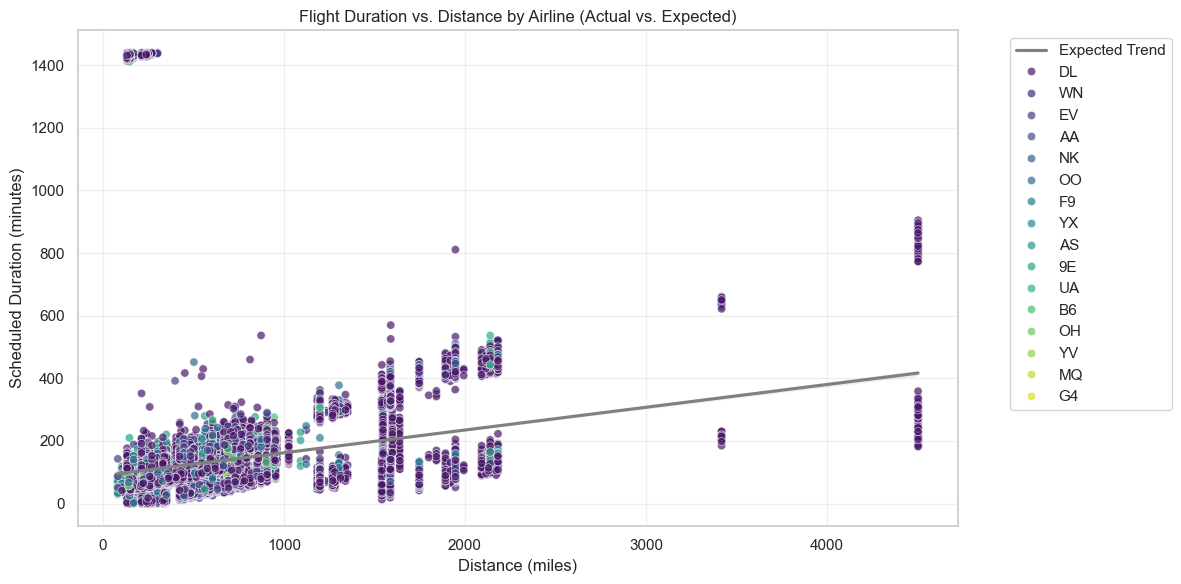

In [61]:
import seaborn as sns  
import matplotlib.pyplot as plt  

plt.figure(figsize=(12, 6))  
sns.regplot(data=df01, x='distance', y='flight_duration_minutes', scatter=False, color='gray', label='Expected Trend')  
sns.scatterplot(data=df01, x='distance', y='flight_duration_minutes', hue='unique_carrier', palette='viridis', alpha=0.7)  
plt.xlabel("Distance (miles)")  
plt.ylabel("Scheduled Duration (minutes)")  
plt.title("Flight Duration vs. Distance by Airline (Actual vs. Expected)")  
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  
plt.grid(alpha=0.3)  
plt.tight_layout()  
plt.show()  

5. Schedule buffer

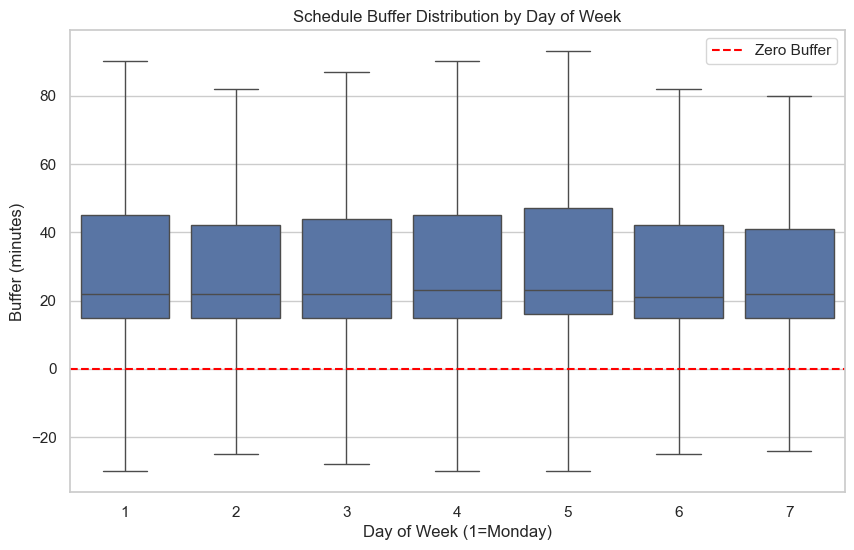

In [62]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df01,
    x='day_of_week',
    y='schedule_buffer',
    showfliers=False  # Hide outliers for cleaner view
)
plt.axhline(0, color='red', linestyle='--', label='Zero Buffer')
plt.title('Schedule Buffer Distribution by Day of Week')
plt.xlabel('Day of Week (1=Monday)')
plt.ylabel('Buffer (minutes)')
plt.legend()
plt.show()

In [63]:
import plotly.express as px

fig = px.scatter(
    df.sample(1000),  # Sample for performance
    x='flight_duration_minutes',
    y='arr_delay',
    color='unique_carrier',
    hover_data=['origin', 'dest', 'distance'],
    title='Flight Duration vs. Arrival Delay (Interactive)'
)
fig.show()

Short flights show greater variability and are more prone to high delays, while long-haul flights tend to arrive more consistently on time. Overall, there is no strong correlation between flight duration and arrival delay, and delays are distributed across all carriers.DL Carrier may have more reported delays simply due to its larger presence in the sample.

In [64]:
import pandas as pd

# Group by carrier and calculate mean and median arrival delay
delay_summary = df.groupby('unique_carrier')['arr_delay'].agg(['count', 'mean', 'median']).reset_index()

# Sort by mean delay descending
delay_summary = delay_summary.sort_values(by='mean', ascending=False)

print(delay_summary)


   unique_carrier  count       mean  median
11             OO   7387  13.977393    -3.0
7              G4     91   8.406593    -5.0
5              EV   9922   6.484076    -8.0
10             OH    739   5.671177    -2.0
13             WN  16370   5.590837    -3.0
0              9E   3484   4.348450    -8.0
6              F9   1387   4.329488    -8.0
3              B6   1283   3.904910   -10.0
9              NK   2924   3.762312    -7.0
8              MQ    106   3.443396    -7.5
1              AA   4666   3.440206    -6.0
14             YV    348   1.827586    -8.5
12             UA   2409   0.850560   -10.0
4              DL  95931  -0.398172    -8.0
15             YX    676  -3.292899   -10.0
2              AS    262  -8.500000   -12.5


Airlines like AS, DL, UA, YX, and B6 show consistent on-time performance with fewer outliers, while carriers like OO and G4 have outlier-influenced delays reflected in a high mean but low median.

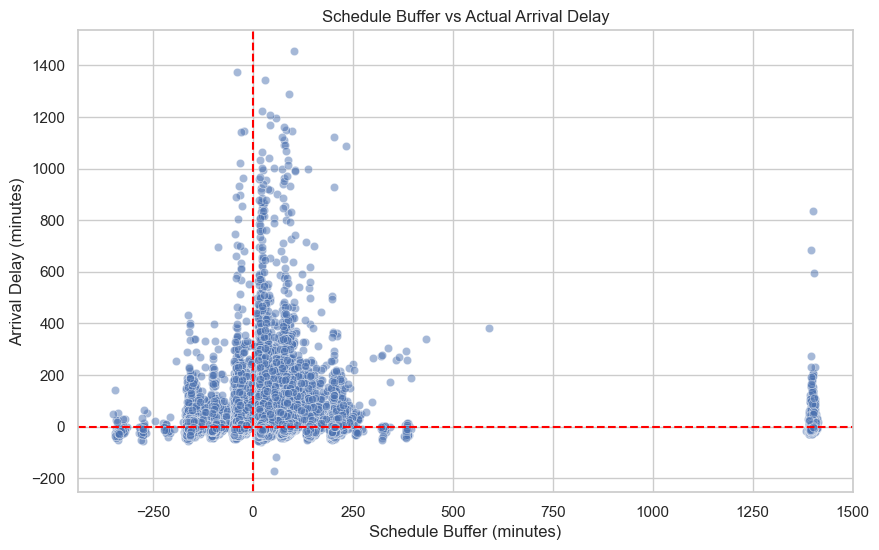

In [65]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df01, x='schedule_buffer', y='arr_delay', alpha=0.5)
plt.axhline(0, color='red', linestyle='--')  # On-time reference
plt.axvline(0, color='red', linestyle='--')  # Zero buffer reference
plt.title('Schedule Buffer vs Actual Arrival Delay')
plt.xlabel('Schedule Buffer (minutes)')
plt.ylabel('Arrival Delay (minutes)')
plt.show()

In [66]:
# Aggregate flight count and delay count by MONTH
monthly_summary = df01.groupby('month')['fl_delayed'].agg(
    total_flights='count',
    delayed_flights='sum'
).reset_index()

# Calculate delay rate
monthly_summary['delay_rate'] = (monthly_summary['delayed_flights'] / monthly_summary['total_flights'] * 100).round(2)
monthly_summary['delay_rate']


0     16.12
1     12.20
2     12.32
3     12.84
4     17.64
5     21.03
6     21.21
7     14.49
8     10.65
9     11.28
10     6.50
11    14.99
Name: delay_rate, dtype: float64

In [67]:
df01.head()

,year,quarter,month,day_of_week,fl_date,unique_carrier,origin,dest,dest_state_abr,arr_time,...,schedule_buffer,month_name,is_weekend,is_holiday,CarrirDelayRate,route,route_delay_rate,arr_hour,arr_time_period,is_delayed
0,2017,3,7,2,2017-07-11,DL,LIT,ATL,GA,0757,...,75,Jul,0,0,0.120,AR : LIT - GA : ATL,0.093525,7,Morning,False
1,2018,1,3,3,2018-03-14,DL,BOS,ATL,GA,2108,...,32,Mar,0,0,0.120,MA : BOS - GA : ATL,0.182540,21,Night,False
2,2017,4,11,7,2017-11-12,WN,ATL,DAL,TX,1451,...,-40,Nov,1,0,0.201,GA : ATL - TX : DAL,0.175287,14,Afternoon,False
3,2017,3,8,2,2017-08-22,EV,ATL,HPN,NY,1408,...,17,Aug,0,0,0.185,GA : ATL - NY : HPN,0.202864,14,Afternoon,False
4,2018,1,3,5,2018-03-02,DL,MSY,ATL,GA,0737,...,76,Mar,0,0,0.120,LA : MSY - GA : ATL,0.133571,7,Morning,False


In [68]:
df01.info()

<class 'pandas.core.frame.DataFrame'>
Index: 147985 entries, 0 to 148051
Data columns (total 29 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   year                     147985 non-null  int64         
 1   quarter                  147985 non-null  int64         
 2   month                    147985 non-null  int64         
 3   day_of_week              147985 non-null  int64         
 4   fl_date                  147985 non-null  datetime64[ns]
 5   unique_carrier           147985 non-null  object        
 6   origin                   147985 non-null  object        
 7   dest                     147985 non-null  object        
 8   dest_state_abr           147985 non-null  object        
 9   arr_time                 147985 non-null  object        
 10  arr_delay                147985 non-null  float64       
 11  air_time                 147985 non-null  int64         
 12  distance             

### Step 5: Data preprocessing

In [69]:
num_features= df01.select_dtypes(include='number')
num_features.columns

Index(['year', 'quarter', 'month', 'day_of_week', 'arr_delay', 'air_time',
       'distance', 'distance_group', 'fl_delayed', 'week',
       'flight_duration_minutes', 'schedule_buffer', 'is_weekend',
       'is_holiday', 'CarrirDelayRate', 'route_delay_rate', 'arr_hour'],
      dtype='object')

In [70]:
num_features

,year,quarter,month,day_of_week,arr_delay,air_time,distance,distance_group,fl_delayed,week,flight_duration_minutes,schedule_buffer,is_weekend,is_holiday,CarrirDelayRate,route_delay_rate,arr_hour
0,2017,3,7,2,-11.0,64,453,2,0,28,139,75,0,0,0.120,0.093525,7
1,2018,1,3,3,-23.0,127,946,4,0,11,159,32,0,0,0.120,0.182540,21
2,2017,4,11,7,-9.0,106,721,3,0,45,66,-40,1,0,0.201,0.175287,14
3,2017,3,8,2,-21.0,113,780,4,0,34,130,17,0,0,0.185,0.202864,14
4,2018,1,3,5,-19.0,59,425,2,0,9,135,76,0,0,0.120,0.133571,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148047,2018,1,1,5,0.0,217,1947,8,0,2,421,204,0,0,0.120,0.191244,22
148048,2017,3,9,5,7.0,100,606,3,0,39,82,-18,0,0,0.211,0.162144,12
148049,2017,2,6,4,-10.0,86,577,3,0,22,112,26,0,0,0.120,0.166151,11
148050,2017,4,11,2,-14.0,52,332,2,0,45,127,75,0,0,0.120,0.139860,16


In [71]:
## columns with object type
cat_features= df01.select_dtypes(include='O')
cat_features.columns

Index(['unique_carrier', 'origin', 'dest', 'dest_state_abr', 'arr_time',
       'origin_state_city', 'dest_state_city', 'month_name', 'route'],
      dtype='object')

In [72]:
## Identifying the unique number of columns
for i in ['unique_carrier', 'origin', 'dest', 'route']:
    print(df01[i].nunique())

16
167
166
383


In [73]:
## Data encoding from categorical to numerical
from sklearn.preprocessing import LabelEncoder

for col in ['year', 'quarter', 'month', 'day_of_week', 'unique_carrier', 'origin', 'dest', 'route', 'arr_time_period']:
    le = LabelEncoder()
    df01[col + '_encoded'] = le.fit_transform(df01[col])

In [74]:
## Dropping  extra columns
df01.drop(columns= ['year', 'quarter', 'month', 'day_of_week', 'unique_carrier', 'origin', 'dest', 'route', 'arr_time_period'], inplace=True)

In [75]:
## Final clean dataset
df02= df01[['year_encoded','quarter_encoded', 'month_encoded', 'day_of_week_encoded',
       'unique_carrier_encoded','CarrirDelayRate', 'origin_encoded', 'dest_encoded',
       'route_encoded','route_delay_rate','arr_time_period_encoded', 'air_time',
       'distance', 'distance_group','flight_duration_minutes', 'schedule_buffer','is_weekend', 
       'is_holiday', 'fl_delayed' ]]
df02.head(3)

,year_encoded,quarter_encoded,month_encoded,day_of_week_encoded,unique_carrier_encoded,CarrirDelayRate,origin_encoded,dest_encoded,route_encoded,route_delay_rate,arr_time_period_encoded,air_time,distance,distance_group,flight_duration_minutes,schedule_buffer,is_weekend,is_holiday,fl_delayed
0,0,2,6,1,4,0.120,92,9,7,0.093525,3,64,453,2,139,75,0,0,0
1,1,0,2,2,4,0.120,18,9,266,0.182540,4,127,946,4,159,32,0,0,0
2,0,3,10,6,13,0.201,9,39,188,0.175287,0,106,721,3,66,-40,1,0,0


### Feature selection process
- CORRELATION

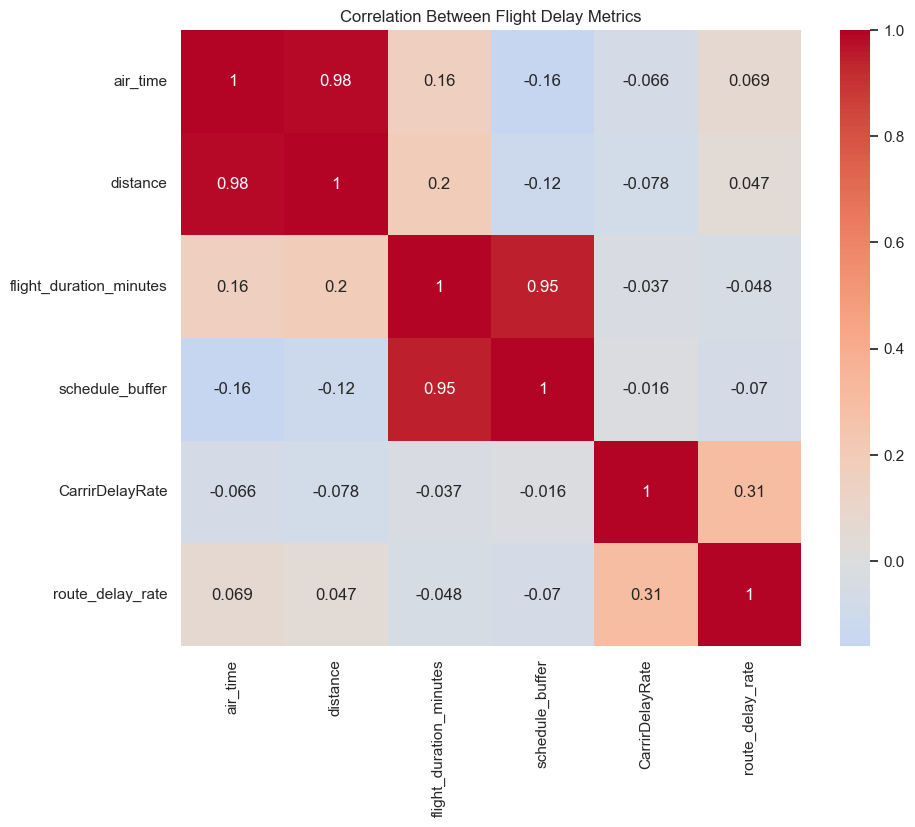

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select numerical columns
num_cols = ['air_time','distance', 'flight_duration_minutes', 'schedule_buffer', 
            'CarrirDelayRate', 'route_delay_rate']

plt.figure(figsize=(10, 8))
sns.heatmap(df02[num_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Between Flight Delay Metrics')
plt.show()

-  VARIANCE INFLATION FACTOR

In [77]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_feature= ['year_encoded','quarter_encoded', 'month_encoded', 'day_of_week_encoded',
       'unique_carrier_encoded','CarrirDelayRate', 'origin_encoded', 'dest_encoded',
       'route_encoded','route_delay_rate','arr_time_period_encoded', 'air_time',
       'distance', 'distance_group','flight_duration_minutes', 'schedule_buffer','is_weekend', 
       'is_holiday', 'fl_delayed']

X = df02[vif_feature].copy()

# Scale the features (important for VIF)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Compute VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = vif_feature
vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

# Sort and display
vif_data = vif_data.sort_values(by="VIF", ascending=False)
print(vif_data)

                    Feature        VIF
14  flight_duration_minutes        inf
15          schedule_buffer        inf
11                 air_time        inf
12                 distance  55.574779
13           distance_group  25.472749
2             month_encoded  19.674719
1           quarter_encoded  17.151139
0              year_encoded   3.015217
3       day_of_week_encoded   2.601263
16               is_weekend   2.545615
5           CarrirDelayRate   2.164764
4    unique_carrier_encoded   1.992192
7              dest_encoded   1.604517
6            origin_encoded   1.567162
9          route_delay_rate   1.189858
8             route_encoded   1.157570
18               fl_delayed   1.039077
17               is_holiday   1.036000
10  arr_time_period_encoded   1.004110


In [78]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_feature= ['year_encoded','month_encoded', 'day_of_week_encoded',
       'unique_carrier_encoded','CarrirDelayRate', 'origin_encoded', 'dest_encoded',
       'route_encoded','route_delay_rate','arr_time_period_encoded',
       'distance', 'flight_duration_minutes','is_weekend', 
       'is_holiday', 'fl_delayed']

X = df02[vif_feature].copy()

# Scale the features (important for VIF)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Compute VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = vif_feature
vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

# Sort and display
vif_data = vif_data.sort_values(by="VIF", ascending=False)
print(vif_data)

                    Feature       VIF
1             month_encoded  3.006795
0              year_encoded  3.002831
2       day_of_week_encoded  2.596959
12               is_weekend  2.545009
4           CarrirDelayRate  2.158592
3    unique_carrier_encoded  1.988876
6              dest_encoded  1.590322
5            origin_encoded  1.539573
8          route_delay_rate  1.183374
7             route_encoded  1.143299
10                 distance  1.095964
11  flight_duration_minutes  1.084622
13               is_holiday  1.034186
14               fl_delayed  1.026988
9   arr_time_period_encoded  1.002941


VIF results show there is multicolleanirity between three features(schedule_buffer = flight_duration_minutes − air_time) so I have to drop 2 of them so I will keep flight_duration_minutes.
Similarly, I will drop distance_group  and quarter_encoded  and these both have association with distance   and month_encoded  respectively.

- CHI SQUARE TEST

In [79]:
from scipy.stats import chi2_contingency
import pandas as pd

# List of categorical features to test
cat_features = [
    'year_encoded','month_encoded', 'day_of_week_encoded',
       'unique_carrier_encoded','origin_encoded', 'dest_encoded',
       'route_encoded','arr_time_period_encoded','is_weekend', 'is_holiday'
]

# Target variable
target = 'fl_delayed'

# Perform chi-square test
for col in cat_features:
    contingency_table = pd.crosstab(df02[col], df02[target])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    significance = " Significant" if p < 0.05 else " Not significant"
    print(f"{col}: p-value = {p:.4f} → {significance}")


year_encoded: p-value = 0.0000 →  Significant
month_encoded: p-value = 0.0000 →  Significant
day_of_week_encoded: p-value = 0.0000 →  Significant
unique_carrier_encoded: p-value = 0.0000 →  Significant
origin_encoded: p-value = 0.0000 →  Significant
dest_encoded: p-value = 0.0000 →  Significant
route_encoded: p-value = 0.0000 →  Significant
arr_time_period_encoded: p-value = 0.0000 →  Significant
is_weekend: p-value = 0.0000 →  Significant
is_holiday: p-value = 0.0001 →  Significant


In [80]:
import numpy as np

def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

for col in cat_features:
    table = pd.crosstab(df01[col], df01['fl_delayed'])
    v = cramers_v(table)
    print(f"{col}: Cramér's V = {v:.4f}")


year_encoded: Cramér's V = 0.0218
month_encoded: Cramér's V = 0.1168
day_of_week_encoded: Cramér's V = 0.0525
unique_carrier_encoded: Cramér's V = 0.0989
origin_encoded: Cramér's V = 0.0774
dest_encoded: Cramér's V = 0.0794
route_encoded: Cramér's V = 0.1146
arr_time_period_encoded: Cramér's V = 0.2228
is_weekend: Cramér's V = 0.0295
is_holiday: Cramér's V = 0.0104


DESCRIPTION: 
All features are statistically significant (p ≈ 0.000) and show some association with delays (Cramér's V > 0), justifying their inclusion despite weak effects for some (e.g., year_encoded).

Low VIF (< 5) confirms no harmful multicollinearity, allowing safe use of temporal (month_encoded), operational (flight_duration_minutes), and categorical (unique_carrier_encoded) features together.

High-impact feature like arr_time_period_encoded (V=0.22) while observed weak ones (e.g., is_holiday, V=0.01).

Key Features to Keep

High-Impact: arr_time_period_encoded (V=0.22, p=0.000) – Strongest delay predictor.

Operational: flight_duration_minutes (VIF=1.08), distance (VIF=1.09) – Low collinearity, high relevance.

Categorical: unique_carrier_encoded (V=0.098, p=0.000) – Airline-specific delays.

Features to Drop

year_encoded (V=0.021), is_holiday (V=0.010) – Statistically insignificant despite low p-values.


#### Features for Model Training
- Including only pre-departure features with significant association to delay: quarter, month, week, day_of_week, unique_carrier_encoded, origin_encoded, dest_encoded, route_encoded, arr_time_period_encoded, is_weekend, is_holiday, and distance.

- Excluding post-flight or target-related features to avoid data leakage: dep_time, arr_time, arr_delay, and air_time.

In [81]:
### Features for model training, droped is_weekend
df03= df02[['year_encoded','month_encoded', 'day_of_week_encoded',
       'unique_carrier_encoded','CarrirDelayRate', 'origin_encoded', 'dest_encoded',
       'route_encoded','route_delay_rate','arr_time_period_encoded',
       'distance', 'flight_duration_minutes', 'is_holiday', 'fl_delayed']]
print(df03.shape)
df03

(147985, 14)


,year_encoded,month_encoded,day_of_week_encoded,unique_carrier_encoded,CarrirDelayRate,origin_encoded,dest_encoded,route_encoded,route_delay_rate,arr_time_period_encoded,distance,flight_duration_minutes,is_holiday,fl_delayed
0,0,6,1,4,0.120,92,9,7,0.093525,3,453,139,0,0
1,1,2,2,4,0.120,18,9,266,0.182540,4,946,159,0,0
2,0,10,6,13,0.201,9,39,188,0.175287,0,721,66,0,0
3,0,7,1,5,0.185,9,74,157,0.202864,0,780,130,0,0
4,1,2,4,4,0.120,110,9,264,0.133571,3,425,135,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148047,1,0,4,4,0.120,87,9,11,0.191244,4,1947,421,0,0
148048,0,8,4,11,0.211,9,116,102,0.162144,0,606,82,0,0
148049,0,5,3,4,0.120,23,9,268,0.166151,3,577,112,0,0
148050,0,10,1,4,0.120,98,9,347,0.139860,0,332,127,0,0


####  Step 6: Model Training

In [82]:
from sklearn.model_selection import train_test_split

X = df03.drop(columns='fl_delayed')
y = df03['fl_delayed']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


In [83]:
## Handling imbalance data
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print("After SMOTE:", y_train_sm.value_counts())


After SMOTE: fl_delayed
1    101338
0    101338
Name: count, dtype: int64


In [84]:
### Normalising data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sm)  
X_test_scaled = scaler.transform(X_test)


#### Logistic Regression and XGBoost
Logistic Regression was used as a transparent, baseline model to benchmark performance and interpret feature effects, while XGBoost was chosen for its ability to capture complex non-linear patterns, handle class imbalance, and optimize performance. This complementary combination ensured both interpretability and predictive power in selecting high-risk flights

In [85]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Model
lr = LogisticRegression(max_iter=1000, solver='liblinear')

# Parameter tuning
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'class_weight': [None, 'balanced']
}

# Grid search
grid_lr = GridSearchCV(lr, param_grid_lr, cv=5, scoring='roc_auc', n_jobs=-1)
grid_lr.fit(X_train_scaled, y_train_sm)

# Best model
best_lr = grid_lr.best_estimator_
print("Best Logistic Regression Params:", grid_lr.best_params_)
print("Best Logistic Regression ROC AUC (CV):", grid_lr.best_score_)

# Evaluate on test set
y_pred_lr = best_lr.predict(X_test_scaled)
print(classification_report(y_test, y_pred_lr))
print("Test ROC AUC:", roc_auc_score(y_test, best_lr.predict_proba(X_test_scaled)[:,1]))


Best Logistic Regression Params: {'C': 0.01, 'class_weight': 'balanced'}
Best Logistic Regression ROC AUC (CV): 0.7337989723005852
              precision    recall  f1-score   support

           0       0.88      0.68      0.77     25335
           1       0.20      0.47      0.28      4262

    accuracy                           0.65     29597
   macro avg       0.54      0.57      0.52     29597
weighted avg       0.79      0.65      0.70     29597

Test ROC AUC: 0.6019606535678594


In [86]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

param_grid_xgb = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200],
    'scale_pos_weight': [6]  # imbalance ratio = majority/minority
}

grid_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, scoring='roc_auc', n_jobs=-1)
grid_xgb.fit(X_train, y_train)

# Best model
best_xgb = grid_xgb.best_estimator_
print("Best XGBoost Params:", grid_xgb.best_params_)
print("Best XGBoost ROC AUC (CV):", grid_xgb.best_score_)

# Evaluate on test set
y_pred_xgb = best_xgb.predict(X_test)
print(classification_report(y_test, y_pred_xgb))
print("Test ROC AUC:", roc_auc_score(y_test, best_xgb.predict_proba(X_test)[:,1]))


Best XGBoost Params: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200, 'scale_pos_weight': 6}
Best XGBoost ROC AUC (CV): 0.7889860071962735
              precision    recall  f1-score   support

           0       0.93      0.78      0.85     25335
           1       0.33      0.65      0.44      4262

    accuracy                           0.76     29597
   macro avg       0.63      0.72      0.64     29597
weighted avg       0.84      0.76      0.79     29597

Test ROC AUC: 0.793312660559669


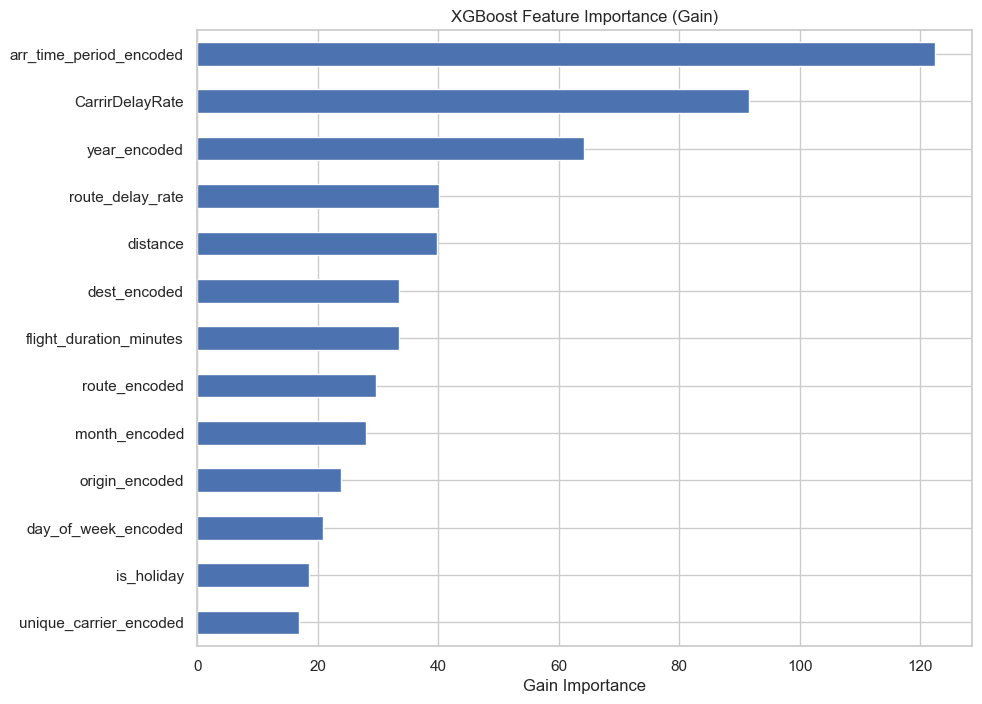

In [87]:
import matplotlib.pyplot as plt
import pandas as pd

# Feature importance by gain (better than default weight)
importances = best_xgb.get_booster().get_score(importance_type='gain')

# Convert to pandas Series and sort
importance_df = pd.Series(importances).sort_values(ascending=True)

# Plot
importance_df.plot(kind='barh', figsize=(10,8), title='XGBoost Feature Importance (Gain)')
plt.xlabel('Gain Importance')
plt.show()



Findings: Logistic Regression vs XGBoost.


ROC AUC: XGBoost (0.79) outperforms Logistic Regression (0.60), indicating better ability to distinguish delayed vs on-time flights.

Accuracy: XGBoost achieves 76% vs Logistic Regression’s 65%; though accuracy is less reliable on imbalanced data, the difference is significant.

Recall (Delayed flights): XGBoost recalls 65%, Logistic Regression 47%. Higher recall is vital to catch more delays and alert users effectively.

Precision (Delayed flights): XGBoost’s precision is 33% vs 20% for Logistic Regression, reducing false delay alerts and improving user experience.

F1-Score: XGBoost (0.44) balances precision and recall better than Logistic Regression (0.28).

Conclusion:

XGBoost is better suited for flight delay prediction due to higher recall, precision, and overall predictive power, leading to more accurate and user-friendly alerts. Logistic Regression, while simpler, underperforms and may cause more missed delays and false alarms.



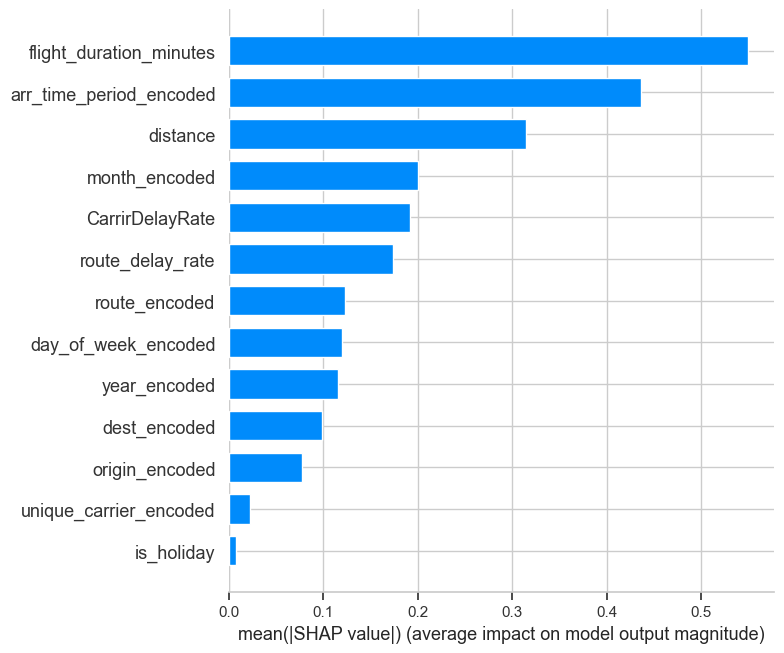

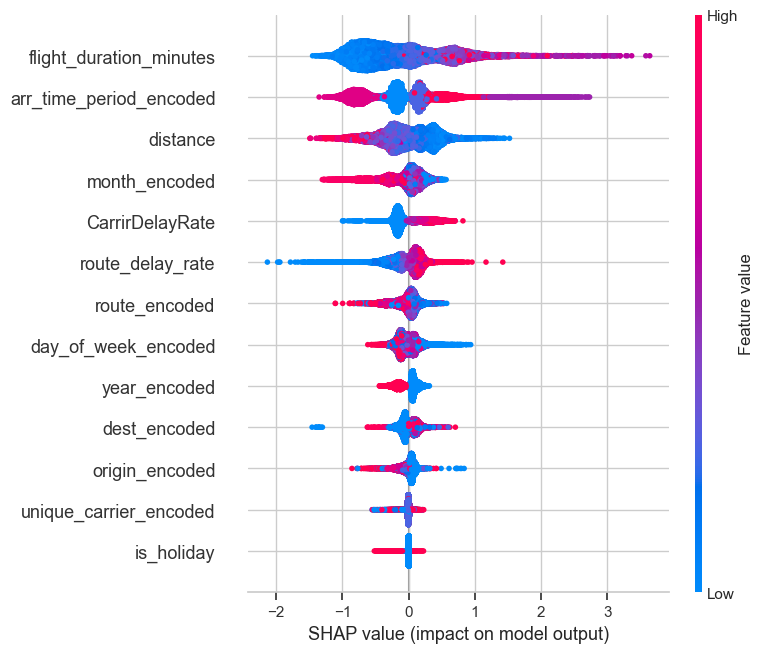

In [88]:

import shap

# Create SHAP explainer
explainer = shap.TreeExplainer(best_xgb)

# Calculate SHAP values for test data
shap_values = explainer.shap_values(X_test)

# Global summary plot - feature importance and effect
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Detailed summary plot - feature values vs impact on prediction
shap.summary_plot(shap_values, X_test)

# Local explanation for a single prediction (e.g., first sample)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])


Summary:
Most important features at the top have the largest spread in SHAP values (both positive and negative impacts).

Color gradient shows how the feature value influences the direction and magnitude of the prediction impact.

Features like flight_duration_minutes and arr_time_period_encoded strongly influence model decisions.

#### Step 7: Model Serialization for deployment

In [89]:
import joblib

# Save
joblib.dump(best_xgb, 'xgboost_flight_delay_model.pkl')
print("Model saved successfully.")

# To load later
# model = joblib.load('xgboost_flight_delay_model.pkl')
# predictions = model.predict(X_new)


Model saved successfully.
